**AER U-Net: attention-enhanced multi-scale residual U-Net structure for water body segmentation using Sentinel-2 satellite images**

> Cecchetto Alessandro - 1941039

> Roccia Emanuele - 1967318


---

# Project aim and selected paper

## Paper selected

* **Selected paper**: AER U-Net: Attention-Enhanced Multi-Scale Residual U-Net Structure for Water Body Segmentation Using Sentinel-2 Satellite Images
* **URL**: https://www.nature.com/articles/s41598-025-99322-z
* **Description**: This paper propose an attention-enhanced multi-scale residual U-Net structure, a modified versione of the U-Net architecture, in order to perform water body segmentation using Sentinel-2 satellite images.

## Project aim

The project aim is the automatic segmentation of water bodies from remote-sensing satellite images, accurate mapping and monitoring of these water bodies are essential for effective water resource management, climate change adaptation, and disaster preparedness. However, extracting water bodies from satellite imagery can be challenging due to factors such as varying water body shapes, diverse environmental conditions, cloud cover, and shadows.

# Theoretical background and key concepts

The paper describes AER U-Net, a modified version of the well-known U-Net architecture tailored for image segmentation tasks.
The AER U-Net incorporates several enhancements over the standard U-Net, combining attention mechanisms, residual learning, and traditional convolutional operations to improve feature propagation and focus.
The architecture relies on a set of basic operations commonly provided by PyTorch:
convolution, batch normalization, dropout, ReLU, sigmoid activations, and max pooling.

These operations are assembled into three fundamental building blocks:
- **Convolutional Block**: consists of a 2D convolution followed by batch normalization and a ReLU activation.
- **Residual Block**: stacks two convolutional blocks with an optional 1x1 convolution for channel matching in the identity path and includes dropout between the convolutions, to provide regularization during training.
- **Attention Block**: uses additive attention to gate features from encoder skip connections, enhancing the decoder's focus on relevant spatial regions.

These components are used to construct higher-level blocks in the network:
- **Encoder**: a sequence of residual blocks followed by max pooling operations, which downsample the spatial dimensions while increasing feature channels.
- **Bottleneck**: a residual block with dropout that acts as the bridge between encoder and decoder.
- **Decoder**: is formed by UpBlock modules that perform upsampling via transposed convolution, apply attention to refine skip connections, and use residual blocks to integrate and transform the combined features.
- Finally, a 1x1 convolution followed by a sigmoid activation generates the segmentation mask.

# Implementation details

We implemented the model using **PyTorch** library, which is used widely for NNs. \\
However, we used additional software and platforms, both to simplify the development and solve some issues:
- **Kaggle suite**: used instead of Google Colab, to benefit from higher usage limits and more powerful hardware in its free plan
- **W&B (Weights and Biases)**: used to collect metrics during training phase and produce corresponding graphs for result presentation
- **Albumentations**: used to pre-process jointly image+mask, as PyTorch applies transforms independently to both and doing so leads to wrong elements in the dataset
- **PyTorch Lightning**: used to reduce boilerplate code to run the model in its three phases (training, validation, testing)

## Setup

### Package installation



In [ ]:
%pip install --quiet \
    albumentations \
    numpy \
    pytorch-lightning \
    torch \
    torchvision \
    wandb

### Libraries imports

In [ ]:
import gc
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix, BinaryF1Score, BinaryJaccardIndex, BinaryPrecision, BinaryRecall

import torchvision
from torchvision.transforms import v2 as T

import wandb

### Cleanup of Python and GPU memory

Using Kaggle we noticed that, if you do not restart the session, the data from the previous runs does not get cleared. \\
Restarting the kernel is a costly operation from the point of view of time, considering that you also need to reinstall PIP packages. \\
We run those commands to clean up manually caches, to experiment quickly with different configurations.

In [ ]:
gc.collect()
torch.cuda.empty_cache()

### Wandb initialization

Insert your WandB key in `wandb_key` variable to see metrics during training and testing.

In [ ]:
wandb_key = "<WANDB_KEY>"
wandb.login(key=wandb_key)

## Reproducibility

To allow users to reproduce consistently our results, we added a global variable (`RANDOM_SEED`) that sets the seed in various random generation algorithms used throughout the code.

It is sufficient to set this variable to make those operations deterministic:
- Dataset split
- Mini-batch split
- Mini-batch ordering
- Dataset augmentation (if any)

In [ ]:
RANDOM_SEED = 147258369

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.manual_seed(RANDOM_SEED)

seed_everything(RANDOM_SEED, workers=True)

## Dataset

The dataset used, as stated in the paper, is taken from Kaggle Hub: `franciscoescobar/satellite-images-of-water-bodies`. \\
It consists of two folders:
- `Images`: contains satellite images of water bodies in variable resolutions
- `Masks`: contains the corresponding binary masks

Every image matches a mask named with the same progressive number (eg. `image_0001.png` and `mask_0001.png`). \\
Images can have varying resolutions but they always match mask resolution. \\
Images contain 3 channels (classic RGB), while masks are still RGB but pixels are strictly black/white. \\
White (`#ffffff`) if the corresponding pixel in the image belongs to a water body, black (`#000000`) if not.

-----

The following code downloads it from Kaggle Hub and stores it in a folder that is returned by `dataset_download()`. \\
Then, the image and mask dirs of the dataset are derived.

In [ ]:
import kagglehub
franciscoescobar_satellite_images_of_water_bodies_path = kagglehub.dataset_download('franciscoescobar/satellite-images-of-water-bodies')

DATASET_ROOT = franciscoescobar_satellite_images_of_water_bodies_path + '/Water Bodies Dataset'
DATASET_IMAGES_DIR = DATASET_ROOT + '/Images'
DATASET_MASKS_DIR = DATASET_ROOT + '/Masks'

### Preprocessing

Dataset pre-processing is done mainly reproducing the paper's workflow. \\
First of all, we defined an image-mask dataset loader class, to load jointly both.

Class `ImageMaskDataset`:
- sorts by name both `Images` and `Masks` folders, to ensure matching between the two.
- converts them into 3-dimensional tensors: images are loaded as RGB into 3 channels, while masks are loaded as grayscale (`L`)
- applies Albumentation transforms which are passed in `self.transform` to class
- ensures image and masks are tensors of shape `[ C, H, W ]`

In [ ]:
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))

        assert len(self.image_files) == len(self.mask_files), "Number of images and masks must be equal"


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        # Load image and mask
        image = PIL.Image.open(img_path).convert('RGB')
        image = np.array(image)

        mask = PIL.Image.open(mask_path).convert('L')
        mask = np.array(mask)

        # Apply transformations if provided
        if self.transform:
            result = self.transform(image=image, mask=mask)
            image = result['image']
            mask = result['mask']

       # Handle mask conversion properly
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float()
        else:
            mask = mask.float()

        # Ensure mask has correct shape [1, H, W] for single channel
        if mask.dim() == 2:  # [H, W]
            mask = mask.unsqueeze(0)  # [1, H, W]

        return image, mask

Class `RemovePaddingTransform` defines an Albumentations-compatible transform to remove padding from both image and mask. \\
It identifies a bounding rectangle which contains the non-black part of the image, then crops the image to that rectangle. \\
It crops the mask using the same rectangle, to ensure `(image, mask)` pair have the same size.

In [ ]:
class RemovePaddingTransform(A.DualTransform):
    def __init__(self):
        super().__init__(p=1.0)

    def get_params_dependent_on_data(self, params, data):
        image = data['image']

        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        coords = cv2.findNonZero(gray)
        if coords is None:
            h, w = image.shape[:2]
            return { 'ymin': 0, 'ymax': h, 'xmin': 0, 'xmax': w }

        x, y, w, h = cv2.boundingRect(coords)

        return { 'ymin': y, 'ymax': y+h, 'xmin': x, 'xmax': x+w }

    def apply(self, img, ymin=None, ymax=None, xmin=None, xmax=None, **params):
        return img[ymin:ymax, xmin:xmax]

    def apply_to_mask(self, mask, ymin=None, ymax=None, xmin=None, xmax=None, **params):
        return mask[ymin:ymax, xmin:xmax]

    def get_targets_as_params(self):
        return [ 'ymin', 'ymax', 'xmin', 'xmax' ]

    def get_transform_init_args_names(self):
        return []

Then, every (image,mask) pair is resized to an uniform image size, defined by `IMAGE_TARGET_SIZE` tuple. \\
This is because the NN requires in input tensors of the same size. \\
In this case, as it is a mask generation network, the input image size must match the output mask size.

In [ ]:
IMAGE_TARGET_SIZE = ( 256, 256 )

The following function takes as input a specific pixel in the mask, uses a threshold of 0.5 to return a true/false value, which gets converted into an integer 0/1 value. \\
It gets applied to mask only using Albumentations Lambda transform.

In [ ]:
def mask_split_threshold(val, **kwargs):
    return (val > 0.5).astype('uint8')

This is the final set of transformations, using Albumentations Compose.
Essentially:
1. Padding is removed
2. Image and masks are resized to a uniform size
3. Pixels are normalized to a value in range [ 0, 1 ]
4. Thresholding is applied (only to mask)
5. Objects are converted to PyTorch tensors


In [ ]:
transform = A.Compose([
    RemovePaddingTransform(),
    A.Resize(*IMAGE_TARGET_SIZE, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=0.0, std=1.0, max_pixel_value=255.0),
    A.Lambda(image=None, mask=mask_split_threshold),
    A.pytorch.ToTensorV2(),
])

Now we load the dataset, calculate the splitting of the three partitions (training, validation, testing), and create the respective loaders. \\
Also, batch size is defined by `DATASET_BATCH_SIZE` variable and passed to the constructor of the loaders.

In [ ]:
DATASET_BATCH_SIZE = 32

dataset = ImageMaskDataset(
    images_dir=DATASET_IMAGES_DIR, masks_dir=DATASET_MASKS_DIR,
    transform=transform,
)

total_size = len(dataset)
train_size = int(total_size * 0.8)
val_size =   int(total_size * 0.1)
test_size = total_size - train_size - val_size

split_generator =  torch.Generator().manual_seed(RANDOM_SEED)
loader_generator = torch.Generator().manual_seed(RANDOM_SEED)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [ train_size, val_size, test_size ], generator=split_generator
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=DATASET_BATCH_SIZE, num_workers=4, shuffle=True, generator=loader_generator)
val_loader =   torch.utils.data.DataLoader(val_dataset,   batch_size=DATASET_BATCH_SIZE, num_workers=4, shuffle=False)
test_loader =  torch.utils.data.DataLoader(test_dataset,  batch_size=DATASET_BATCH_SIZE, num_workers=4, shuffle=False)

## Model

In this section the actual model and building blocks are defined. \\
The code should be self-describing. However, particular steps are commented.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.3):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, out_channels)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = ConvBlock(out_channels, out_channels)

        # If input channels do not match output channels, apply a 1x1 convolution
        # to ensure the matching, otherwise the element-wise addition in skip
        # connection fails
        if in_channels != out_channels:
            self.conv0 = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=False)
        else:
            self.conv0 = None

    def forward(self, x):
        identity = x

        if self.conv0 is not None:
            identity = self.conv0(identity)

        out = self.conv1(x)
        out = self.dropout(out)
        out = self.conv2(out)

        return out + identity

In [ ]:
class AttentionBlock(nn.Module):
    # F_g: number of channels for global features (from decoder block)
    # F_l: number of channels for local  features (from encoder block)
    # F_int: number of channels after first convs and before last conv
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(g1 + x1)
        out = x * psi
        return out

In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # [ in_channels, H, W ] -> [ out_channels, H, W ]
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # concat([ out_channels, H, W ] | [out_channels, H, W]) -> [ out_channels, H, W ]
        self.resblock = ResidualBlock(out_channels * 2, out_channels)

    def forward(self, x, skip, attention):
        x = self.up(x)
        skip = attention(g=x, x=skip)
        x = torch.cat((skip, x), dim=1)
        return self.resblock(x)

In [ ]:
class AERUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = ResidualBlock(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ResidualBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = ResidualBlock(128, 256)
        self.bn_dropout = nn.Dropout2d(p=0.3)

        self.attn2 = AttentionBlock(128, 128, 64)
        self.up2 = UpBlock(256, 128)

        self.attn1 = AttentionBlock(64, 64, 32)
        self.up1 = UpBlock(128, 64)

        self.attn0 = AttentionBlock(32, 32, 16)
        self.up0 = UpBlock(64, 32)

        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x0 = x
        x1 = self.pool1(self.enc1(x0))
        x2 = self.pool1(self.enc1(x1))
        x3 = self.pool1(self.enc1(x2))

        # Bottleneck
        x4 = self.bottleneck(x3)
        x4 = self.bn_dropout(x4)

        # Decoder
        x5 = self.up2(x4, x3, self.attn2)
        x6 = self.up1(x5, x2, self.attn1)
        x7 = self.up0(x6, x1, self.attn0)

        return self.sigmoid(self.final_conv(x7))

## Experimental setup

`LitAERUnet` class defines a module for PyTorch Lightning using the `AERUNet` class, which is the real PyTorch model. \\
It defines metrics used throughout validation and testing, their update at each step and the logging of intermediate and final results.

In [ ]:
class LitAERUNet(pl.LightningModule):
    def __init__(self, model, lr=1e-4):
        super().__init__()
        self.model = model
        self.lr = lr

        self.criterion = nn.BCEWithLogitsLoss()

        # Training metrics
        self.train_accuracy = BinaryAccuracy()

        # Validation metrics
        self.val_accuracy = BinaryAccuracy()
        self.val_iou = BinaryJaccardIndex()

        # Testing metrics
        self.test_accuracy = BinaryAccuracy()
        self.test_recall = BinaryRecall()
        self.test_precision = BinaryPrecision()
        self.test_f1 = BinaryF1Score()
        self.test_iou = BinaryJaccardIndex()
        self.test_confusion_matrix = BinaryConfusionMatrix()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=8,
            verbose=True
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_iou',
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        acc = self.train_accuracy(y_hat, y.int())

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc",  acc,  on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        acc = self.val_accuracy(y_hat, y.int())
        iou = self.val_iou(y_hat, y.int())

        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_iou',  iou,  prog_bar=True, on_epoch=True)
        self.log("val_acc",  acc,  prog_bar=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_int = y.int()

        loss = self.criterion(y_hat, y)
        acc = self.test_accuracy(y_hat, y_int)
        precision = self.test_precision(y_hat, y_int)
        recall = self.test_recall(y_hat, y_int)
        f1 = self.test_f1(y_hat, y_int)
        iou = self.test_iou(y_hat, y.int())

        self.log("test_loss", loss)
        self.log("test_acc", acc)
        self.log("test_precision", precision)
        self.log("test_recall", recall)
        self.log("test_f1", f1)
        self.log("test_iou", iou)

        self.test_confusion_matrix(y_hat, y_int)

    def on_test_epoch_end(self):
        # Compute final test metrics and store them
        self.final_test_acc = self.test_accuracy.compute()
        self.final_test_precision = self.test_precision.compute()
        self.final_test_recall = self.test_recall.compute()
        self.final_test_iou = self.test_iou.compute()
        self.final_test_f1 = self.test_f1.compute()
        self.final_confusion_matrix = self.test_confusion_matrix.compute()

        # Reset metrics for next test run
        self.test_accuracy.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_iou.reset()
        self.test_confusion_matrix.reset()

    def print_detailed_test_results(self):
        if not hasattr(self, 'final_test_acc'):
            print("No test results available. Run testing first.")
            return

        print(f"\n")
        print(f"{'='*50}")
        print(f"  TEST RESULTS  ")
        print(f"{'='*50}")
        print(f"Accuracy:  {self.final_test_acc:.4f}")
        print(f"Precision: {self.final_test_precision:.4f}")
        print(f"Recall:    {self.final_test_recall:.4f}")
        print(f"F1-Score:  {self.final_test_f1:.4f}")
        print(f"IoU:       {self.final_test_iou:.4f}")

        cm = self.final_confusion_matrix
        print(f"\n")
        print(f"Confusion Matrix:")
        print(f"                   Predicted")
        print(f"                 0           1")
        print(f"Actual   0   {cm[0,0]:4d}   {cm[0,1]:4d}")
        print(f"         1   {cm[1,0]:4d}   {cm[1,1]:4d}")


        # Confusion matrix graphic plot
        cm = cm.cpu().numpy()
        labels = ['0', '1']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

### Training

This part of the code defines objects needed for training phase.

If you want to directly test the model using a checkpoint file, skip directly to **Testing** section.

Start a new Wandb session with name `final-run`:

In [ ]:
wandb.finish()

wandb_logger = WandbLogger(
    project="nn-project",
    name="final-run",
    log_model=True
)

Initialize `ModelCheckpoint` callback, which saves periodically the entire model according to the specification:

In [ ]:
output_dir = "/model_checkpoints"
os.makedirs(output_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    dirpath=output_dir,
    filename="current-model",
    mode="max",
    monitor="val_acc",
    save_last=False,
    save_top_k=1,
    save_weights_only=False,
    verbose=True
)

Define `EarlyStopping` callback, which stops training after 20 epochs where the val_iou does not improve:

In [ ]:
early_stop = EarlyStopping(
    mode="max",
    monitor="val_iou",
    patience=20,
    verbose=True
)

Define `LearningRateMonitor` callback, that monitors learning rate throughout the training.

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

Instantiate the model and its Lightning wrapper:

In [ ]:
aerunet = AERUNet(in_channels=3, out_channels=1)
lit_model = LitAERUNet(aerunet, lr=1e-4)

Create a Lighning trainer using features defined above:

In [ ]:
trainer = pl.Trainer(
    accelerator="auto",
    accumulate_grad_batches=4,
    callbacks=[ early_stop, lr_monitor, checkpoint ],
    default_root_dir="./",
    deterministic=True,
    enable_progress_bar=True,
    gradient_clip_val=1.0,
    logger=wandb_logger,
    log_every_n_steps=5,
    max_epochs=5000,
    precision="16-mixed",
)

Print training setup and start the real training phase:

In [ ]:
print(f"[+] Training setup:")
print(f"- Dataset batch size: {DATASET_BATCH_SIZE}, image size: {IMAGE_TARGET_SIZE}")
print(f"- Max epochs: {trainer.max_epochs}")
print(f"- Checkpoints will be saved to: {output_dir}")
print(f"- Early stopping patience: {early_stop.patience}")
print(f"- Batches gradient accumulation: {trainer.accumulate_grad_batches}\n")

trainer.fit(
    lit_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

print("\n[+] Training completed!")
if trainer.current_epoch < trainer.max_epochs - 1:
    print(f"- Early stopping triggered at: {trainer.current_epoch} epochs")
else:
    print(f"- Training completed all {trainer.max_epochs} epochs")

print(f"- Best model saved at: {checkpoint.best_model_path}")
print(f"- Best validation accuracy: {checkpoint.best_model_score}\n")

### Testing

To test the resulting model after the training phase:

In [ ]:
print("\n[+] Starting testing with current trained model")
checkpoint_path = "./current-model.ckpt"

results = trainer.test(dataloaders=test_loader, ckpt_path=checkpoint_path)
print(f"\n[+] Test results: {results}")

detailed_metrics = lit_model.print_detailed_test_results()

To test directly the provided best model without training, load in the Colab environment the provided model `best-model.ckpt`:

In [ ]:
print("\n[+] Starting testing with best model")
checkpoint_path = "./best-model.ckpt"

aerunet = AERUNet(in_channels=3, out_channels=1)
lit_model = LitAERUNet.load_from_checkpoint(checkpoint_path, model=aerunet, lr=1e-4)

tester = pl.Trainer(
    accelerator="auto",
    deterministic=True,
    enable_progress_bar=True,
    log_every_n_steps=5,
    precision="16-mixed",
)

results = tester.test(lit_model, dataloaders=test_loader, ckpt_path=checkpoint_path)
print(f"\n[+] Test results: {results}")

detailed_metrics = lit_model.print_detailed_test_results()

 # Results and analysis

The paper recommends the following settings for training phase:
- Adam optimizer
- Binary cross-entropy loss function
- ReduceLROnPlateau scheduler
- EarlyStopping callback

However, there are some parameters which are not specified (ie. batch size) or defined inconsistently:

- **Batch size** is not defined: we experimented with several settings, as we have an hardware limitation (see next section).

- **Learning rate** is defined as 0.0001 (1e-4) in the complete algorithm in page 7, while is defined twice as 0.001 (1e-3) in page 6. We experimented with both.

- The paper does not include a **validation set**, but dataset is split 80% into training set and 20% into testing set. \\
We rearranged the partitions into: 80% training set, 10% validation set, 10% testing set.

- The metric to consider for **early stopping** is not defined: we used IoU as, in our case, it is the most significant metric with a patience of 20.

- The factor for **ReduceLROnPlateau** is not specified: we settled on 0.5 according to our experiments with a patience of 8.

### Best result

The best results achieved by our implementation are obtained setting:
- Image size: 256x256
- Batch size: 32
- Gradient accumulation: 4
- Learning rate: 0.001
- ReduceLROnPlateau factor: 0.5

Leading to the following final metrics during testing:
- **Accuracy**: 0.8435
- **Precision**: 0.9186
- **Recall**: 0.6848
- **F1-score**: 0.7829
- **IoU**: 0.6447

The **confusion matrix** is:

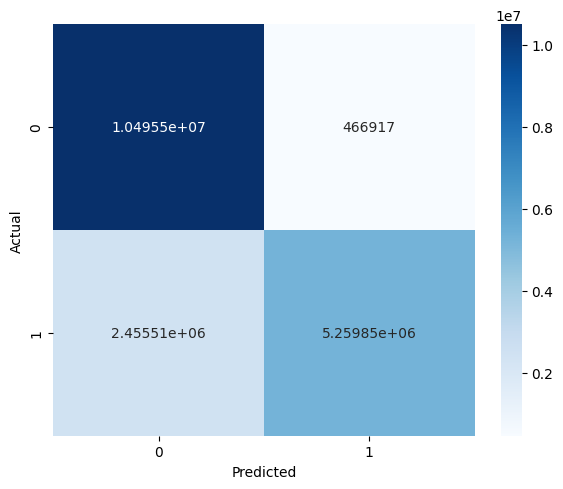

These are the corresponding **metrics plot**:

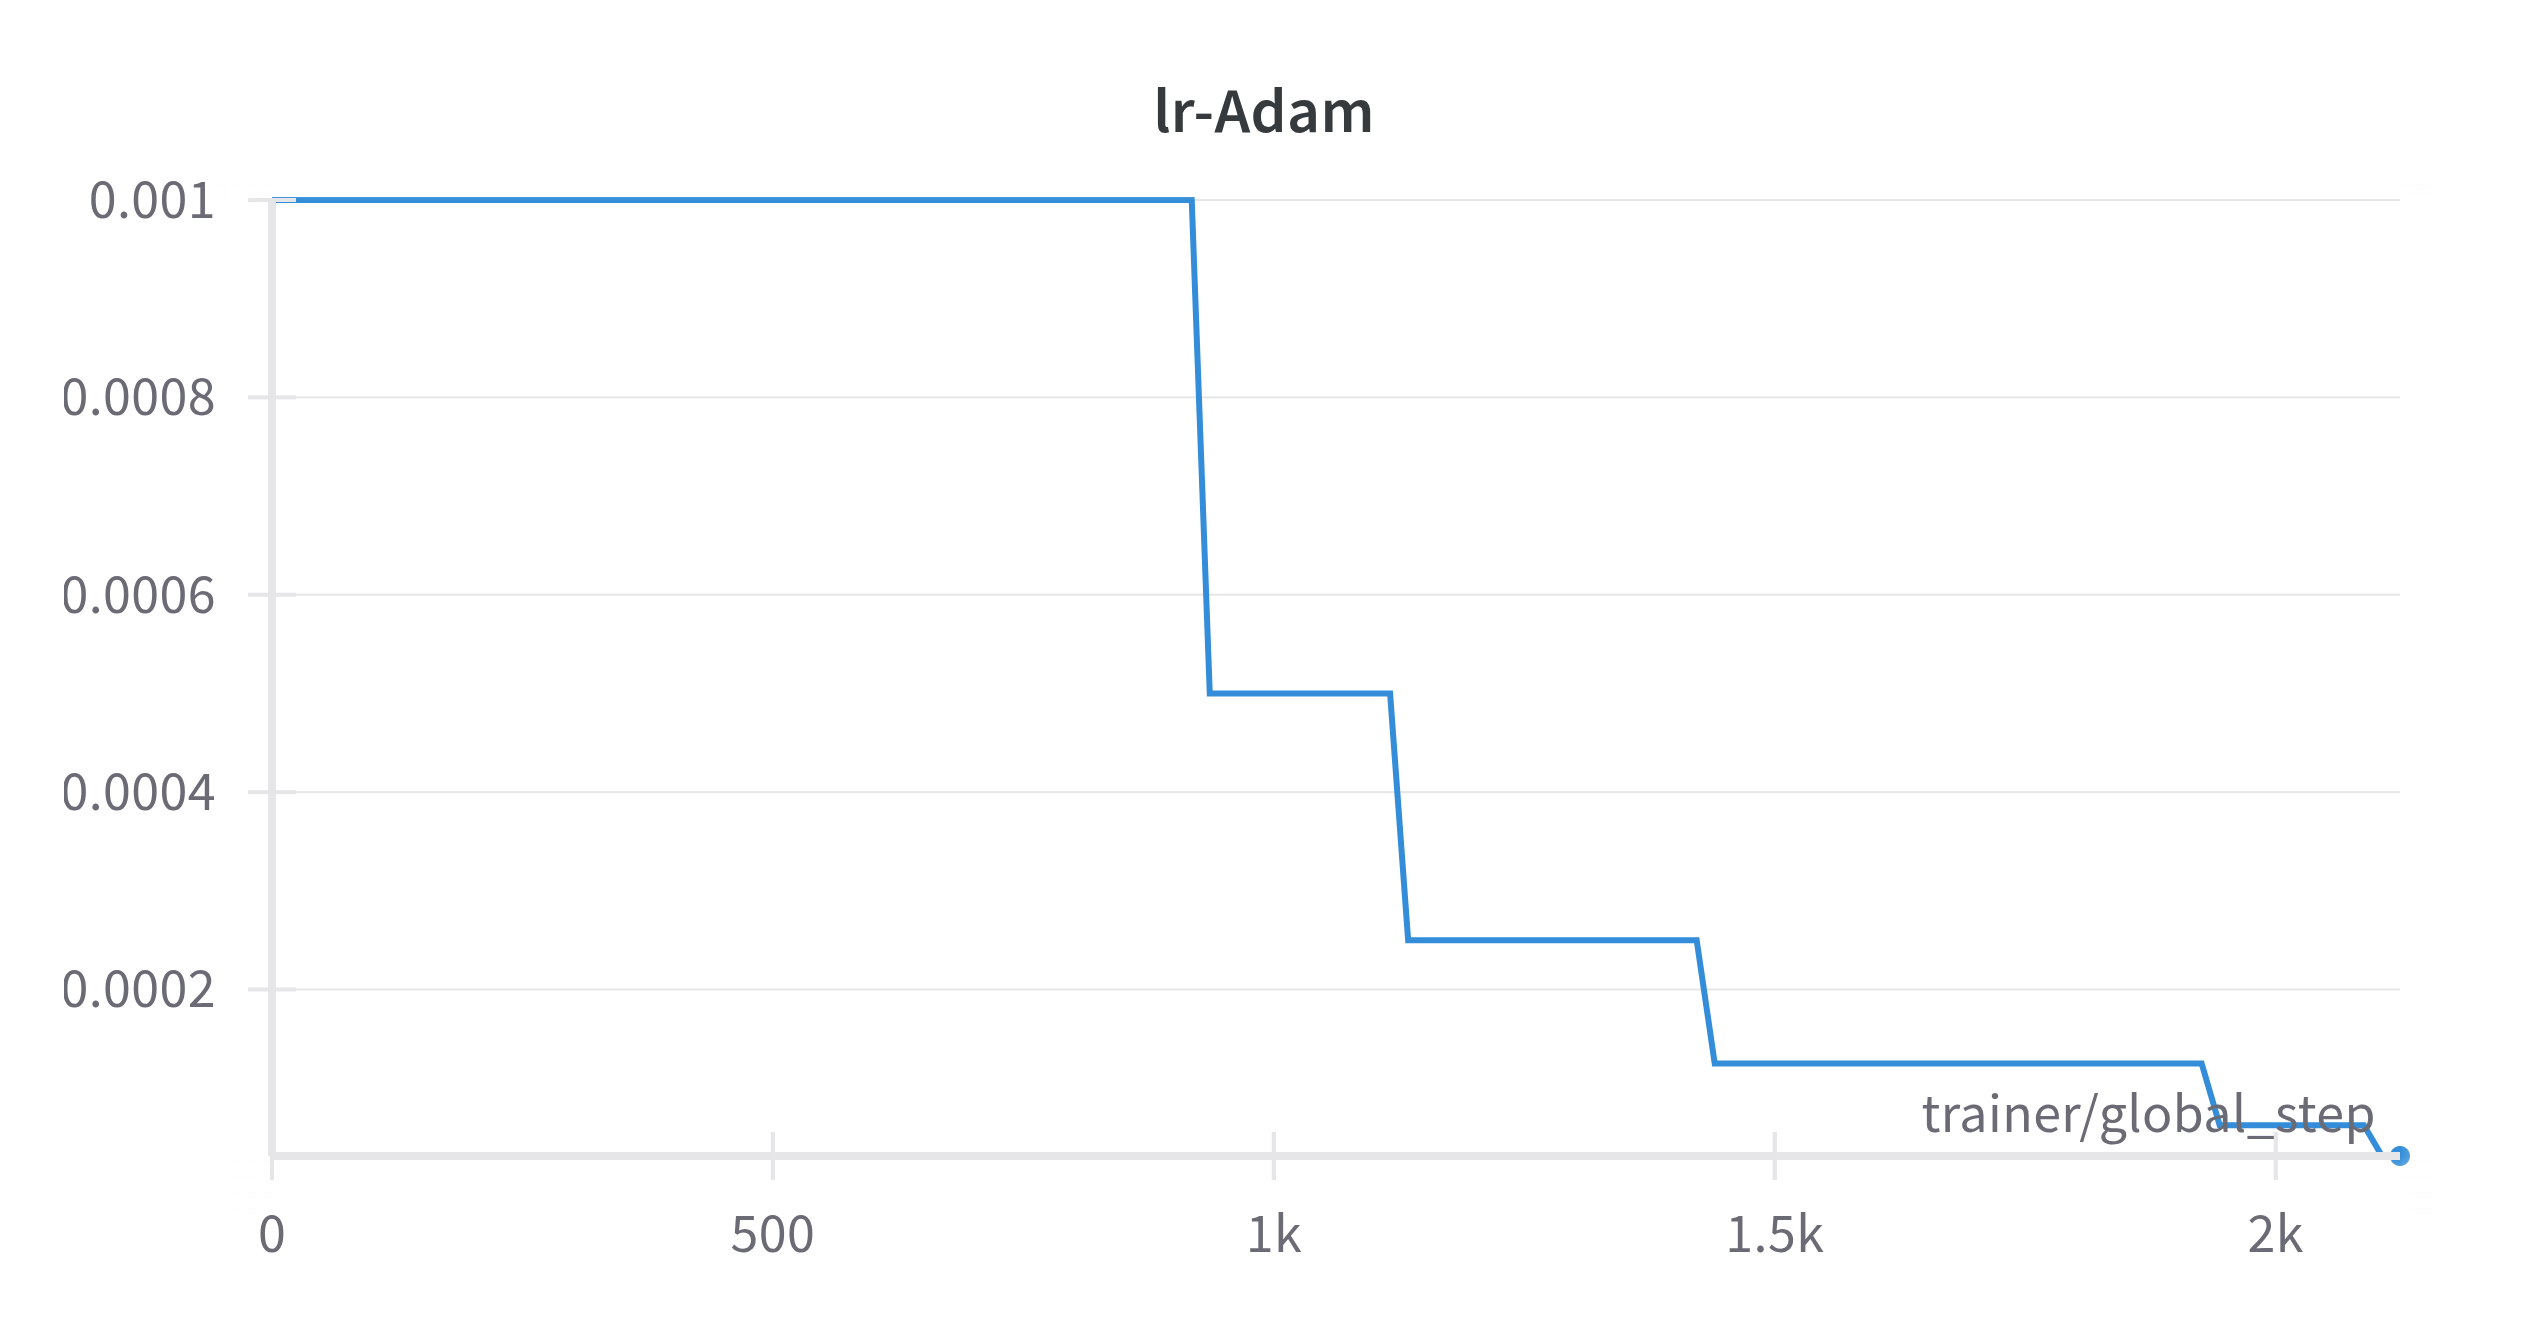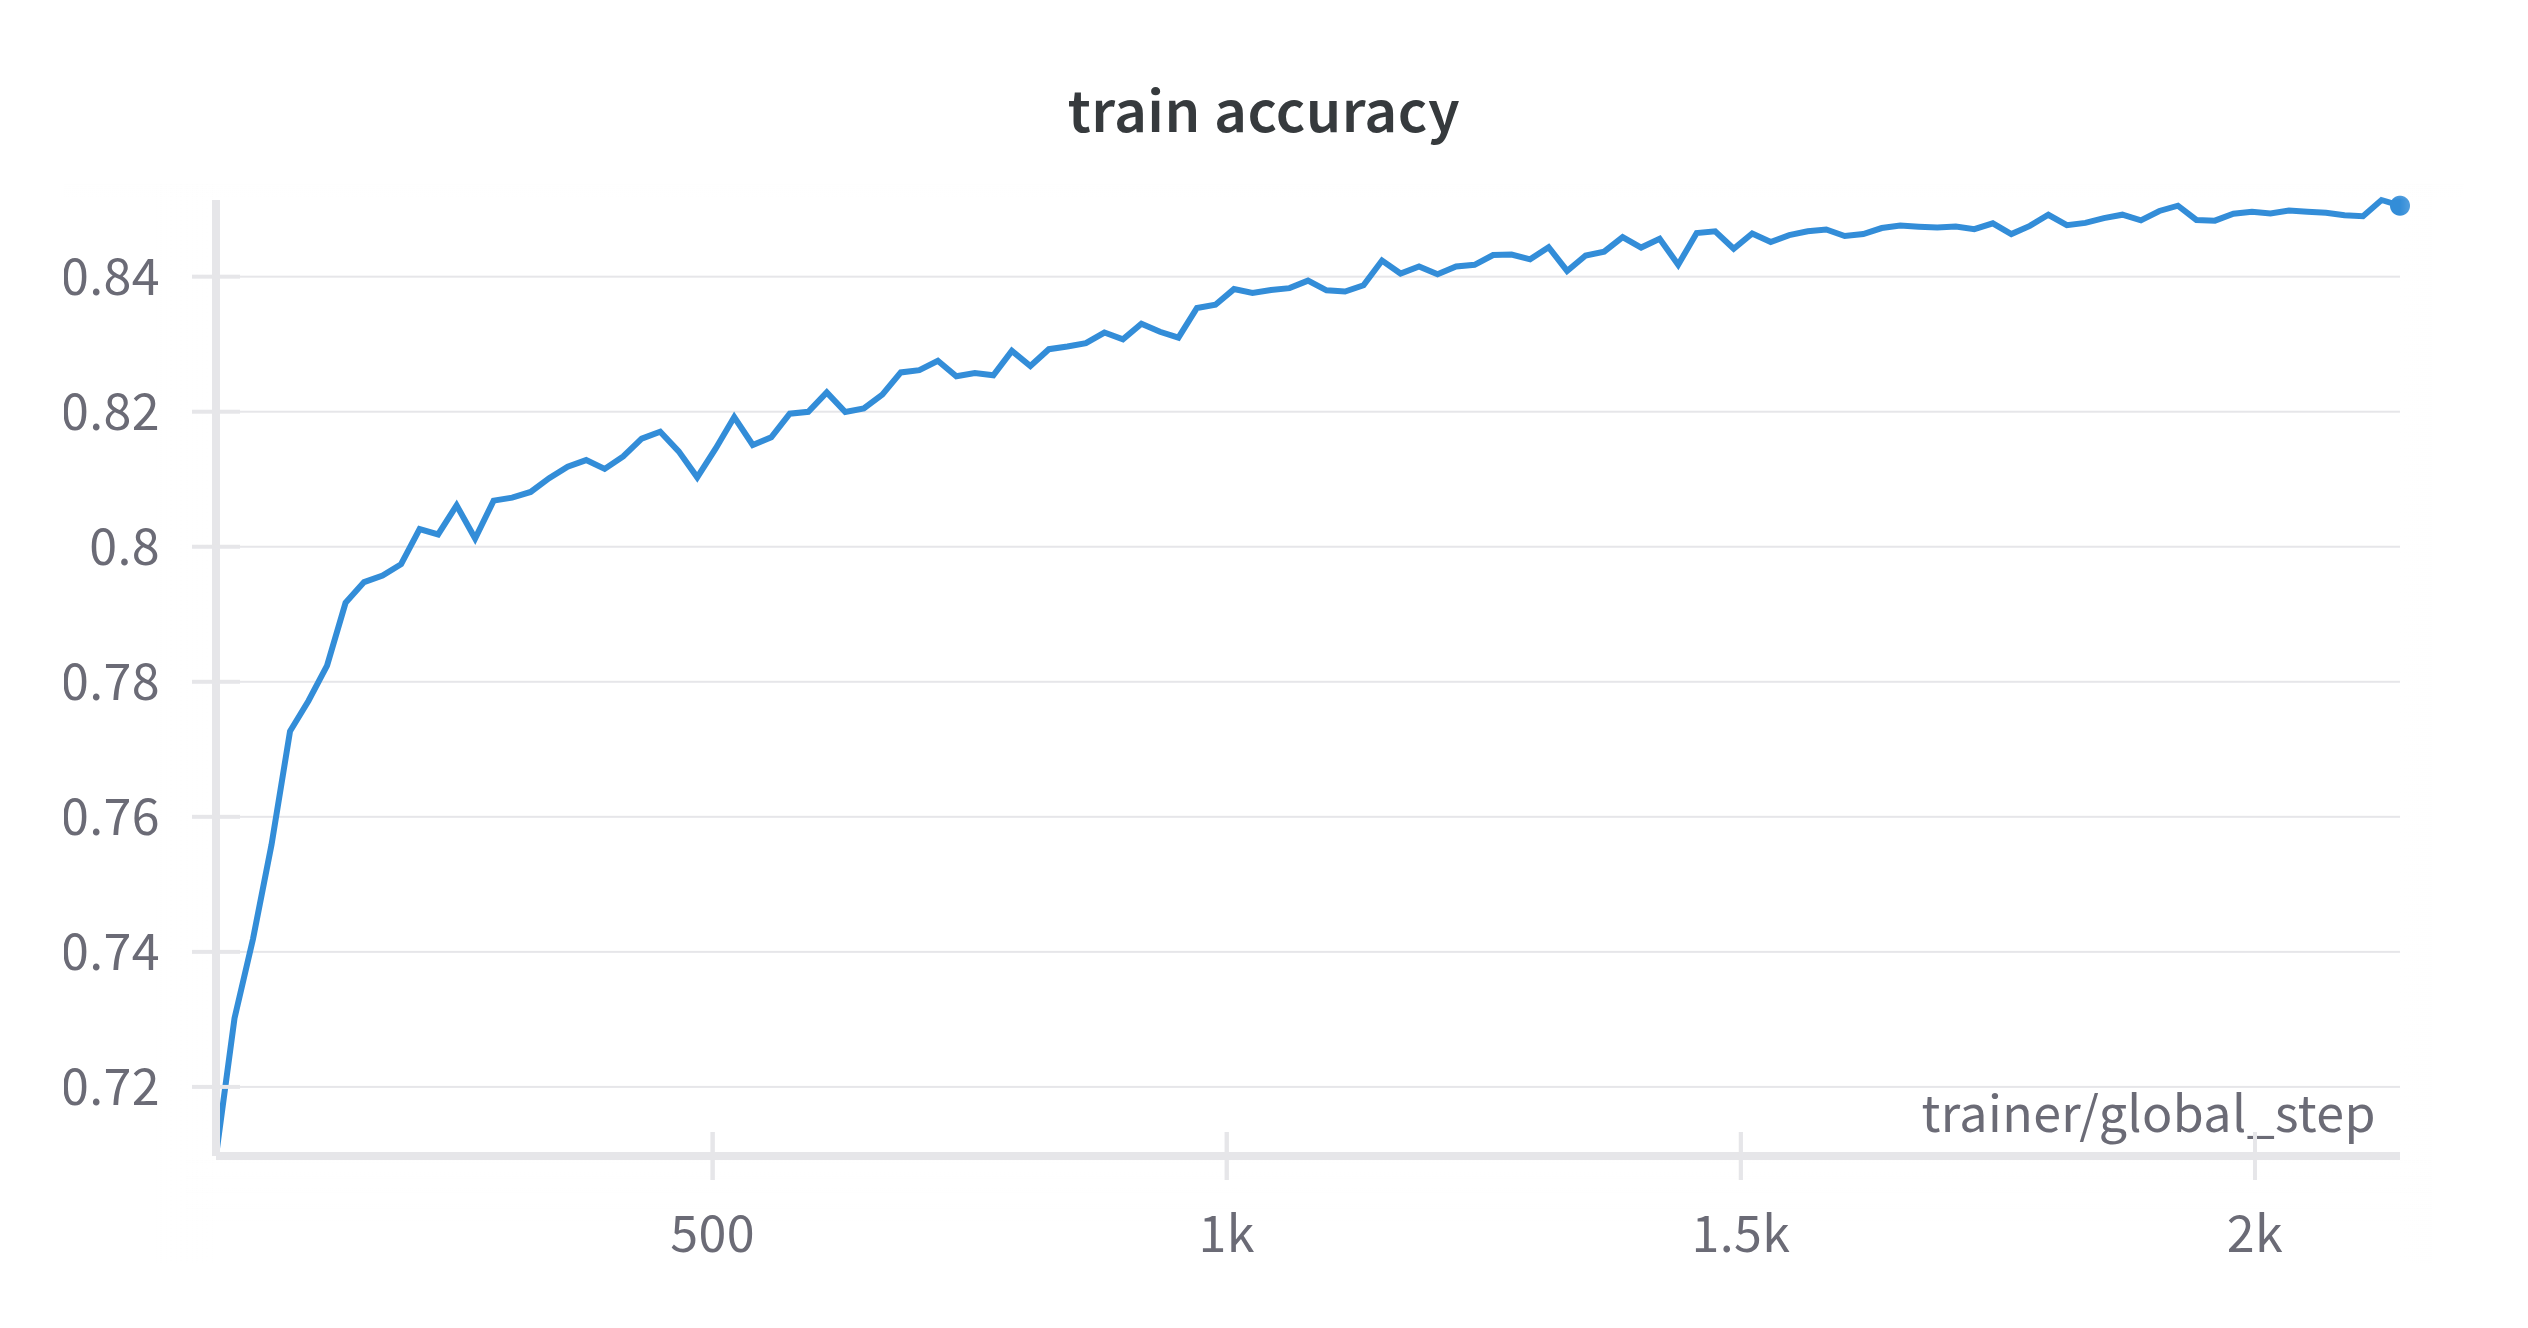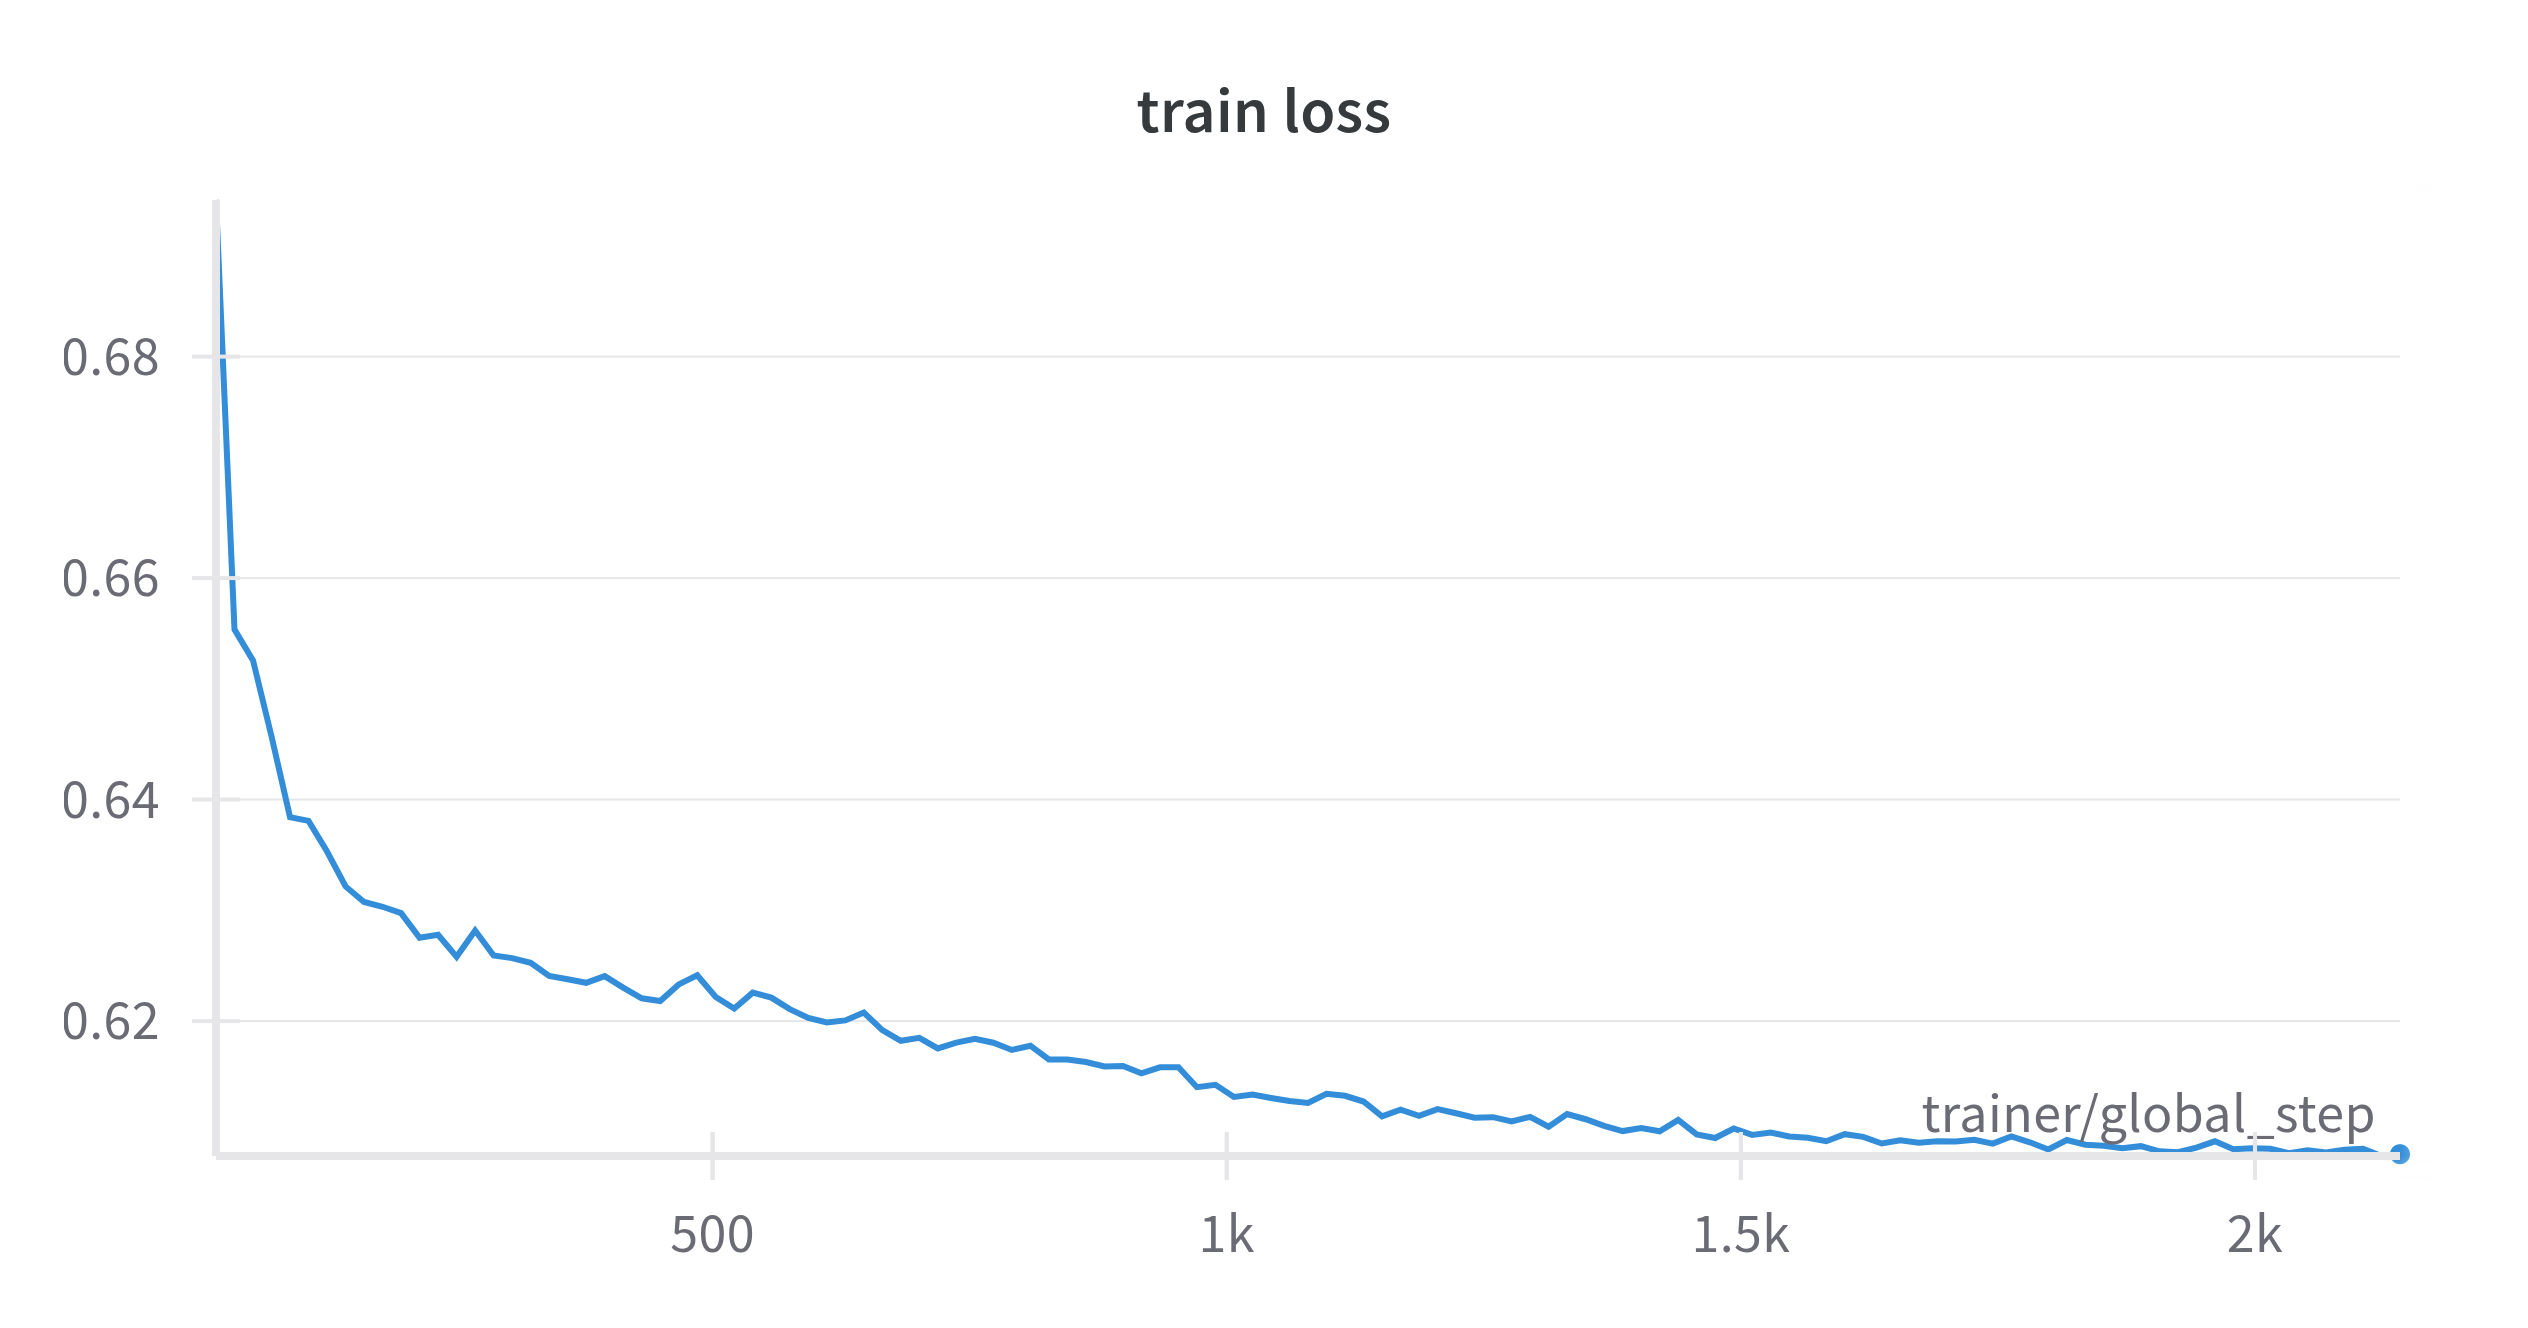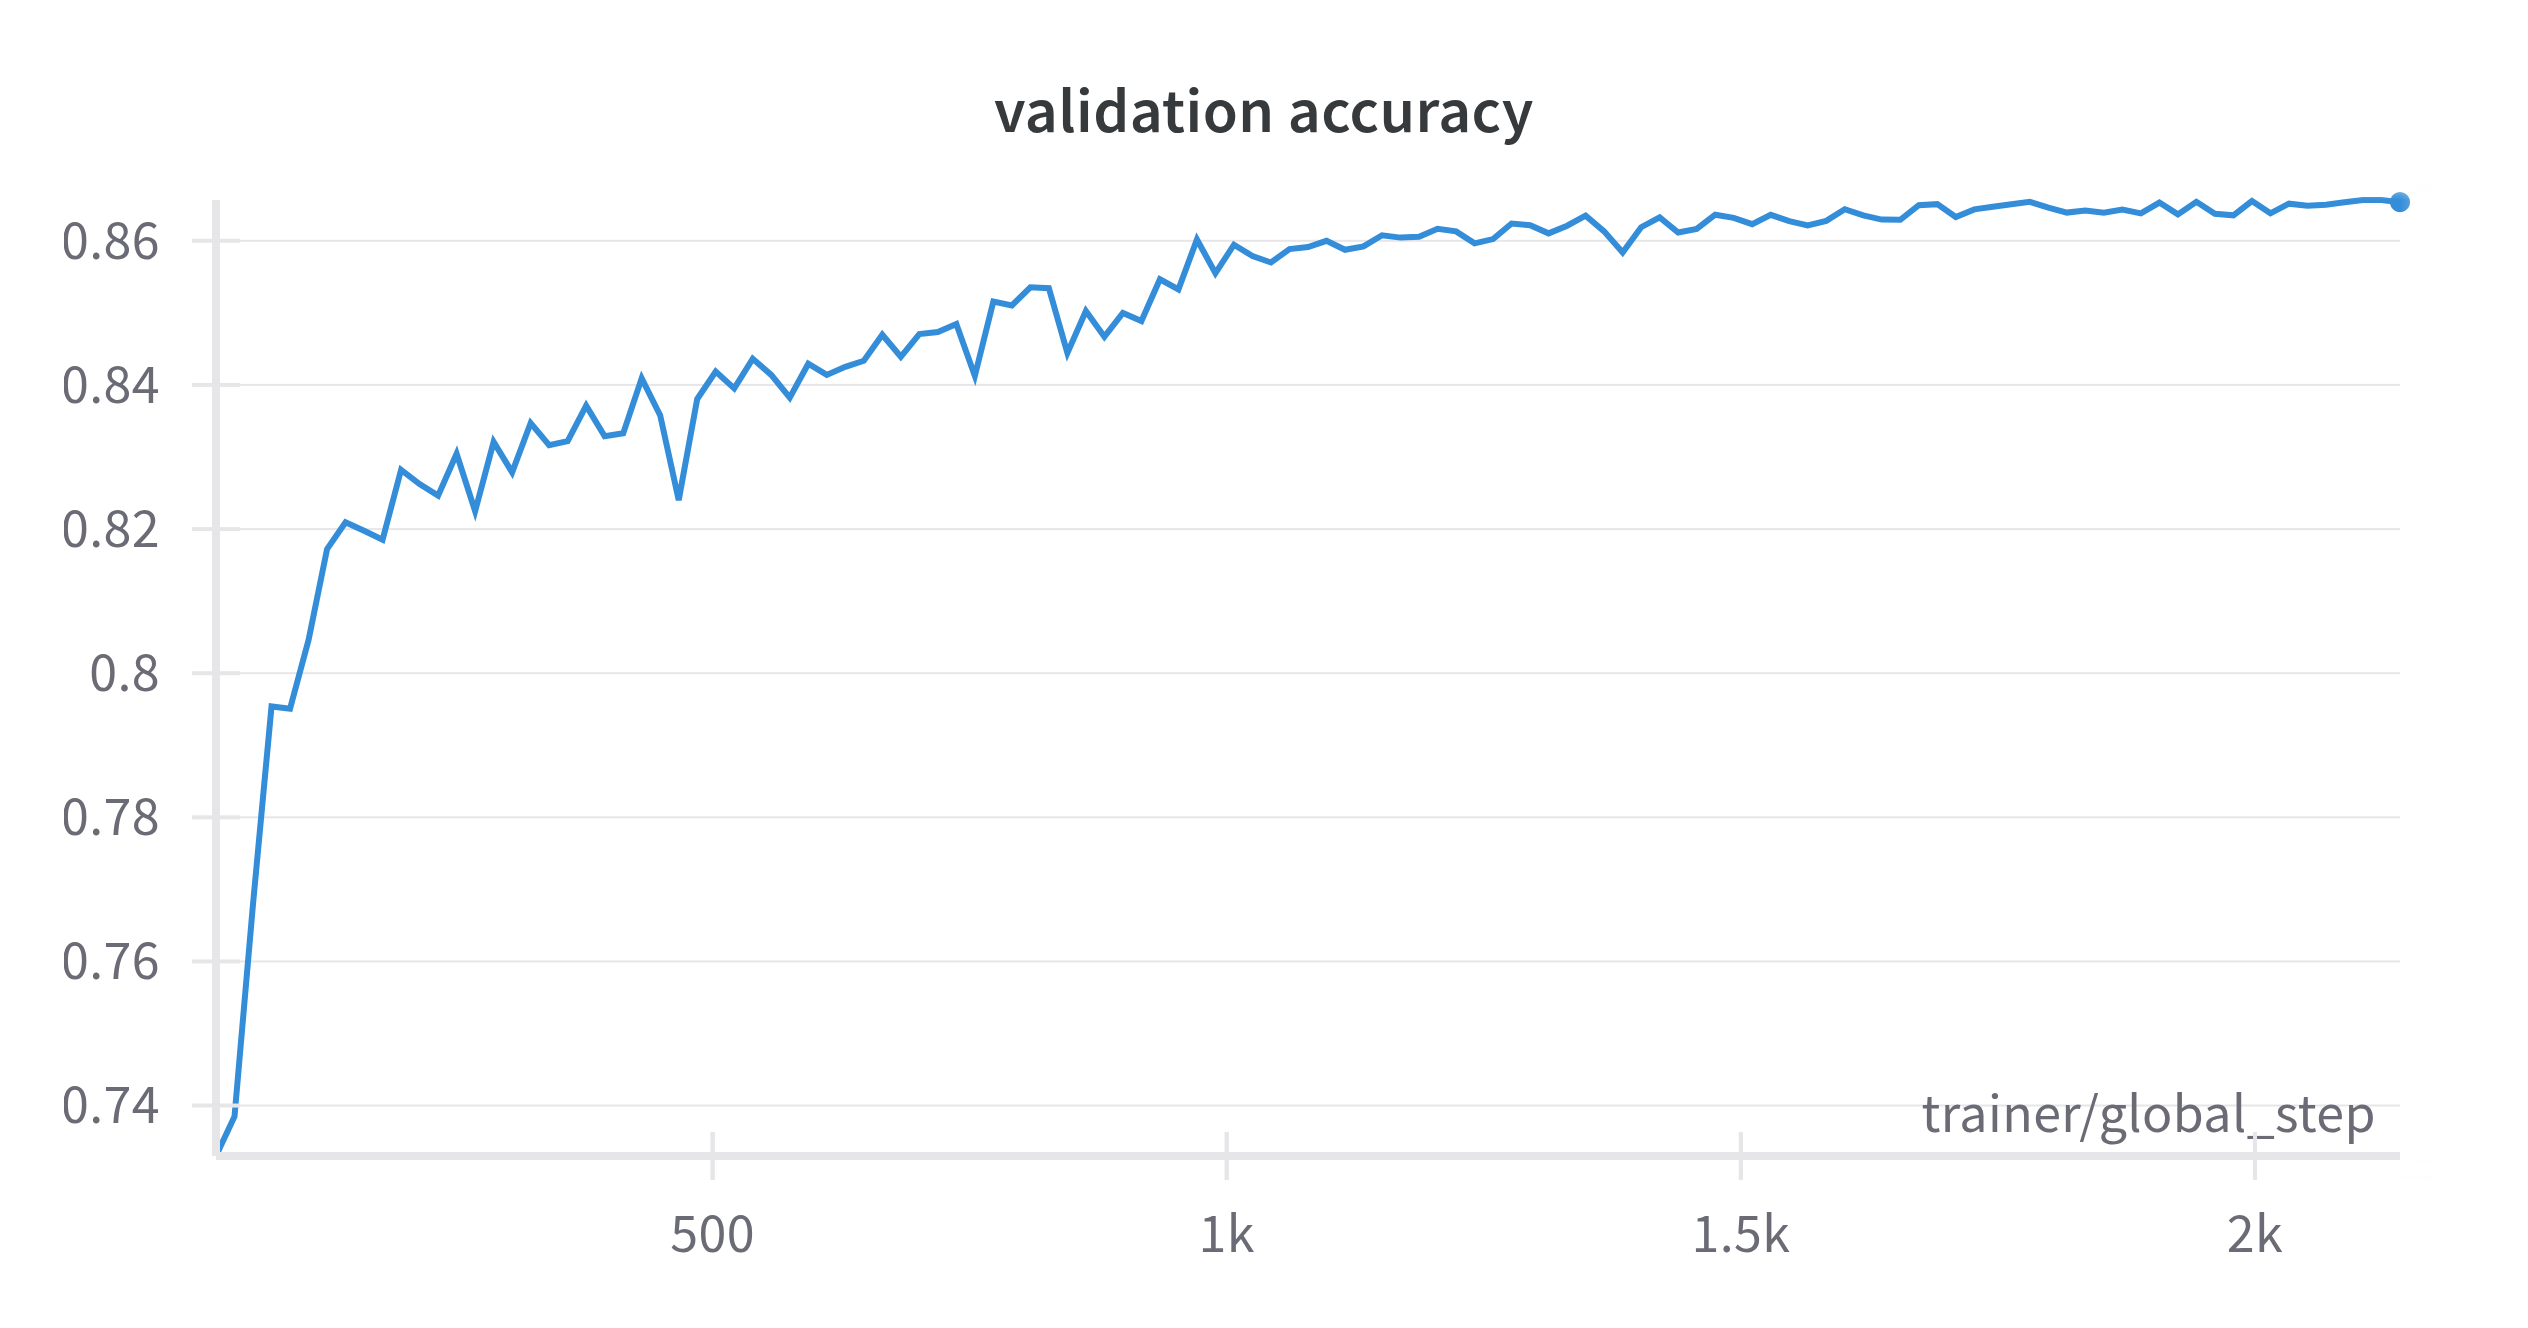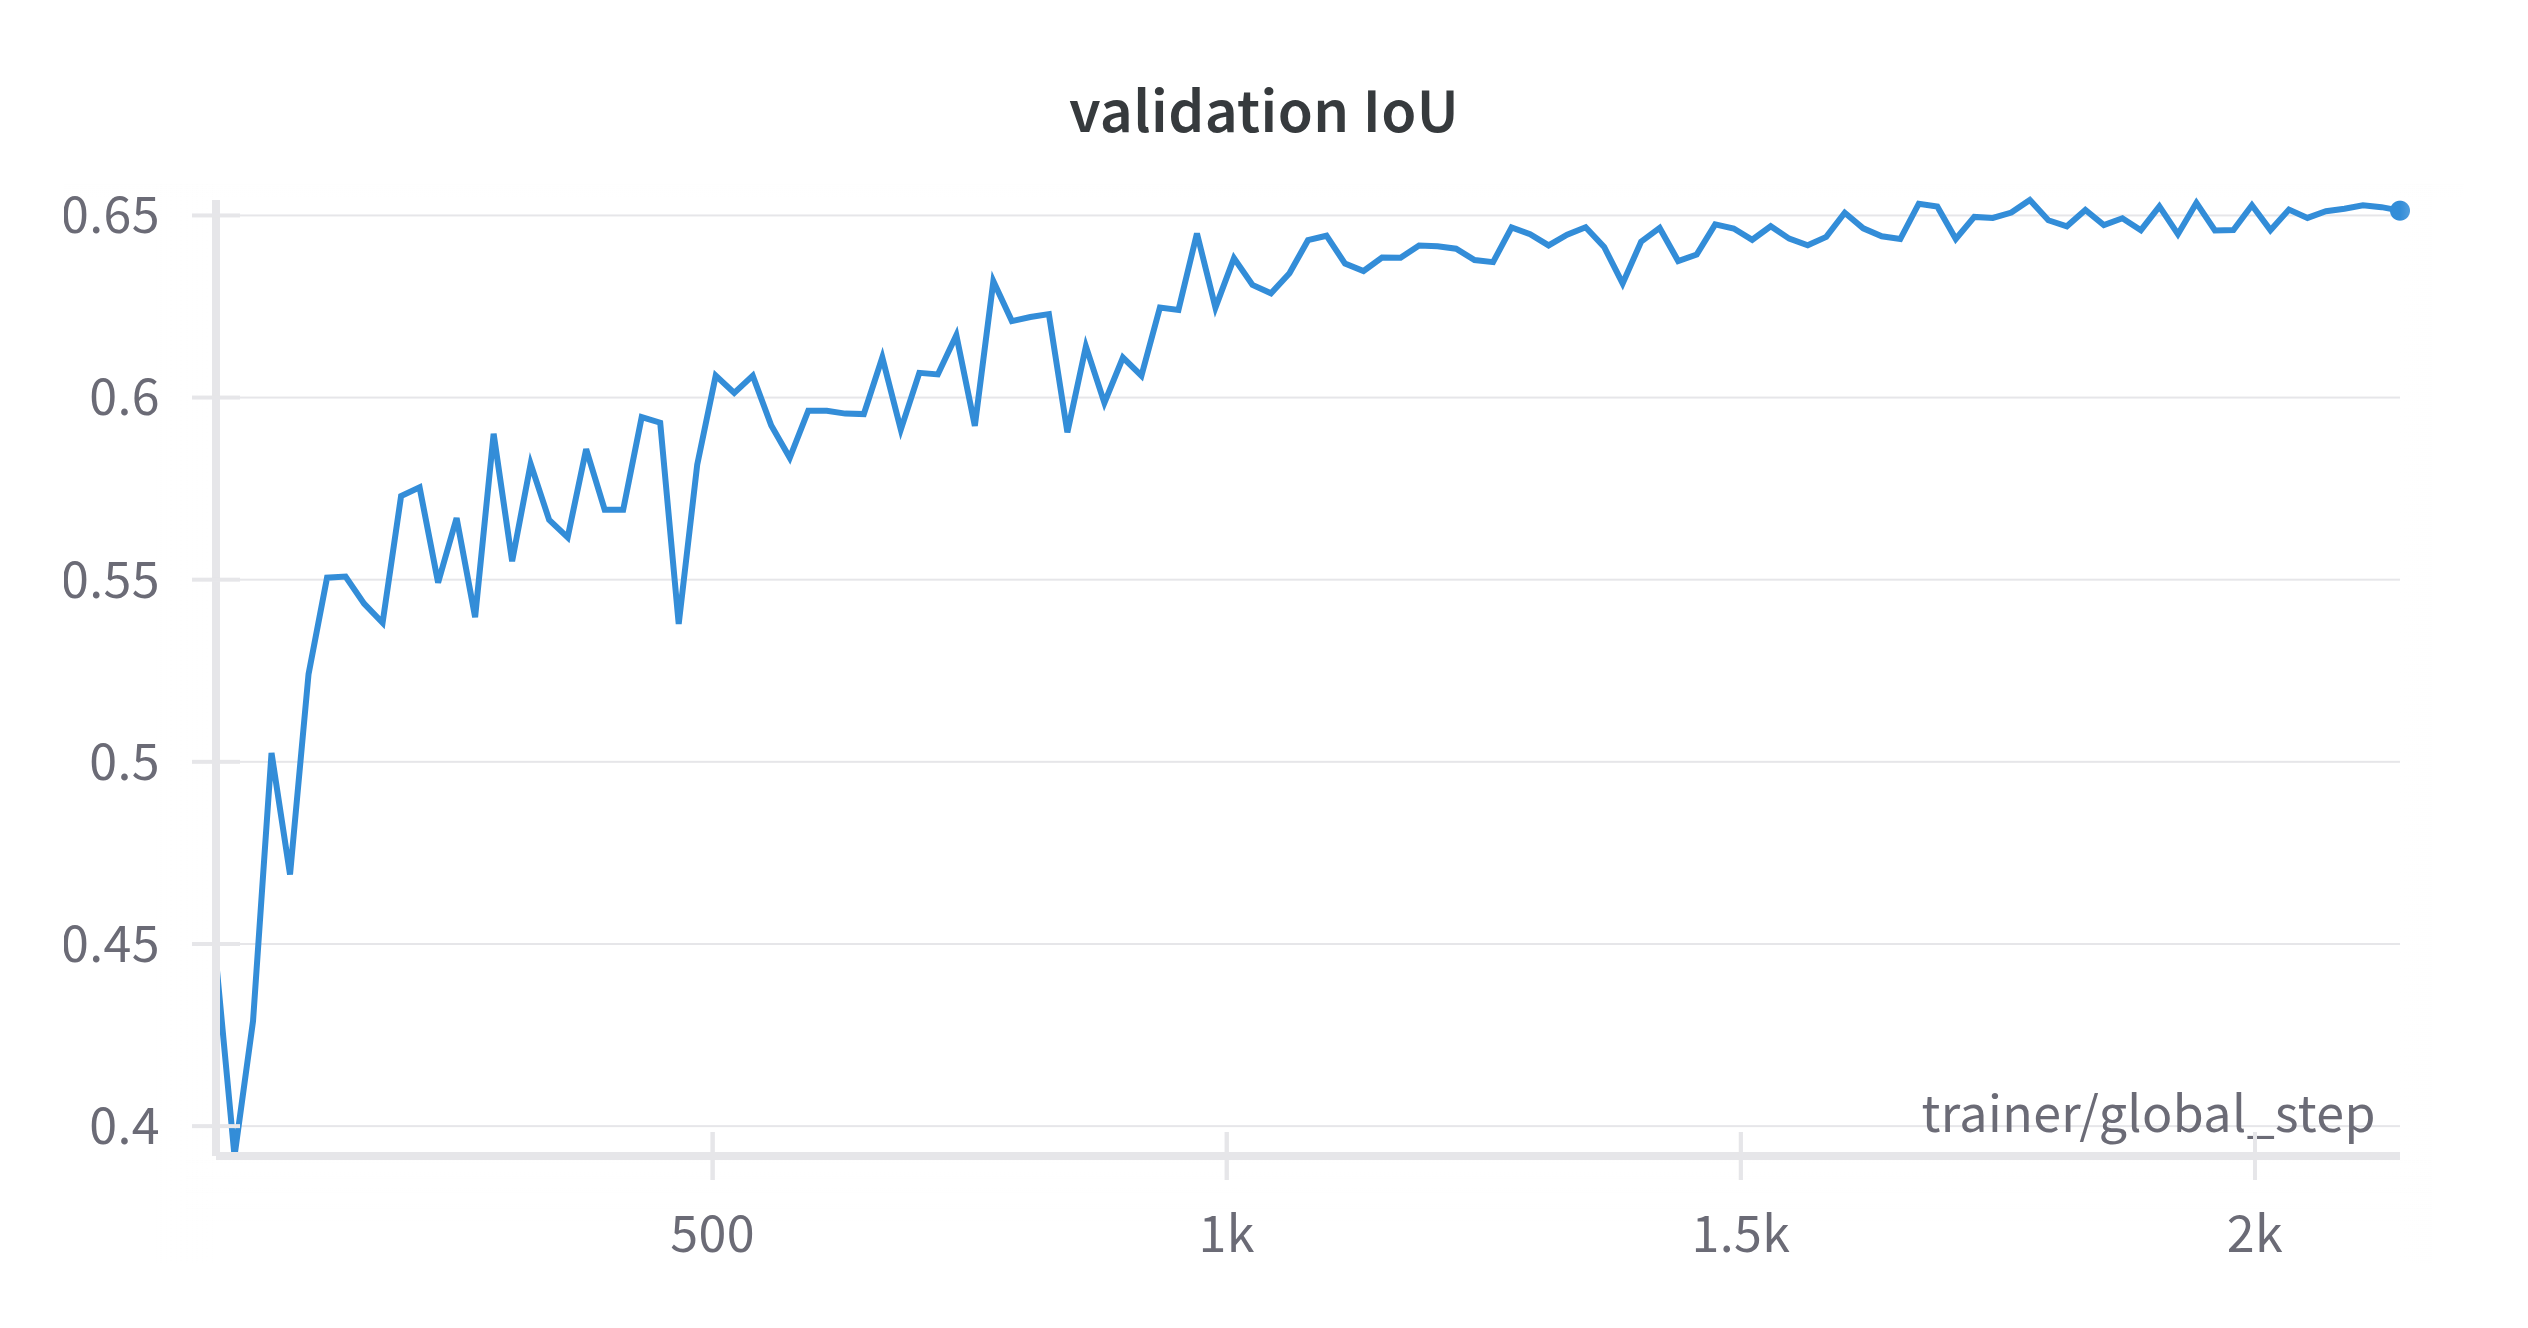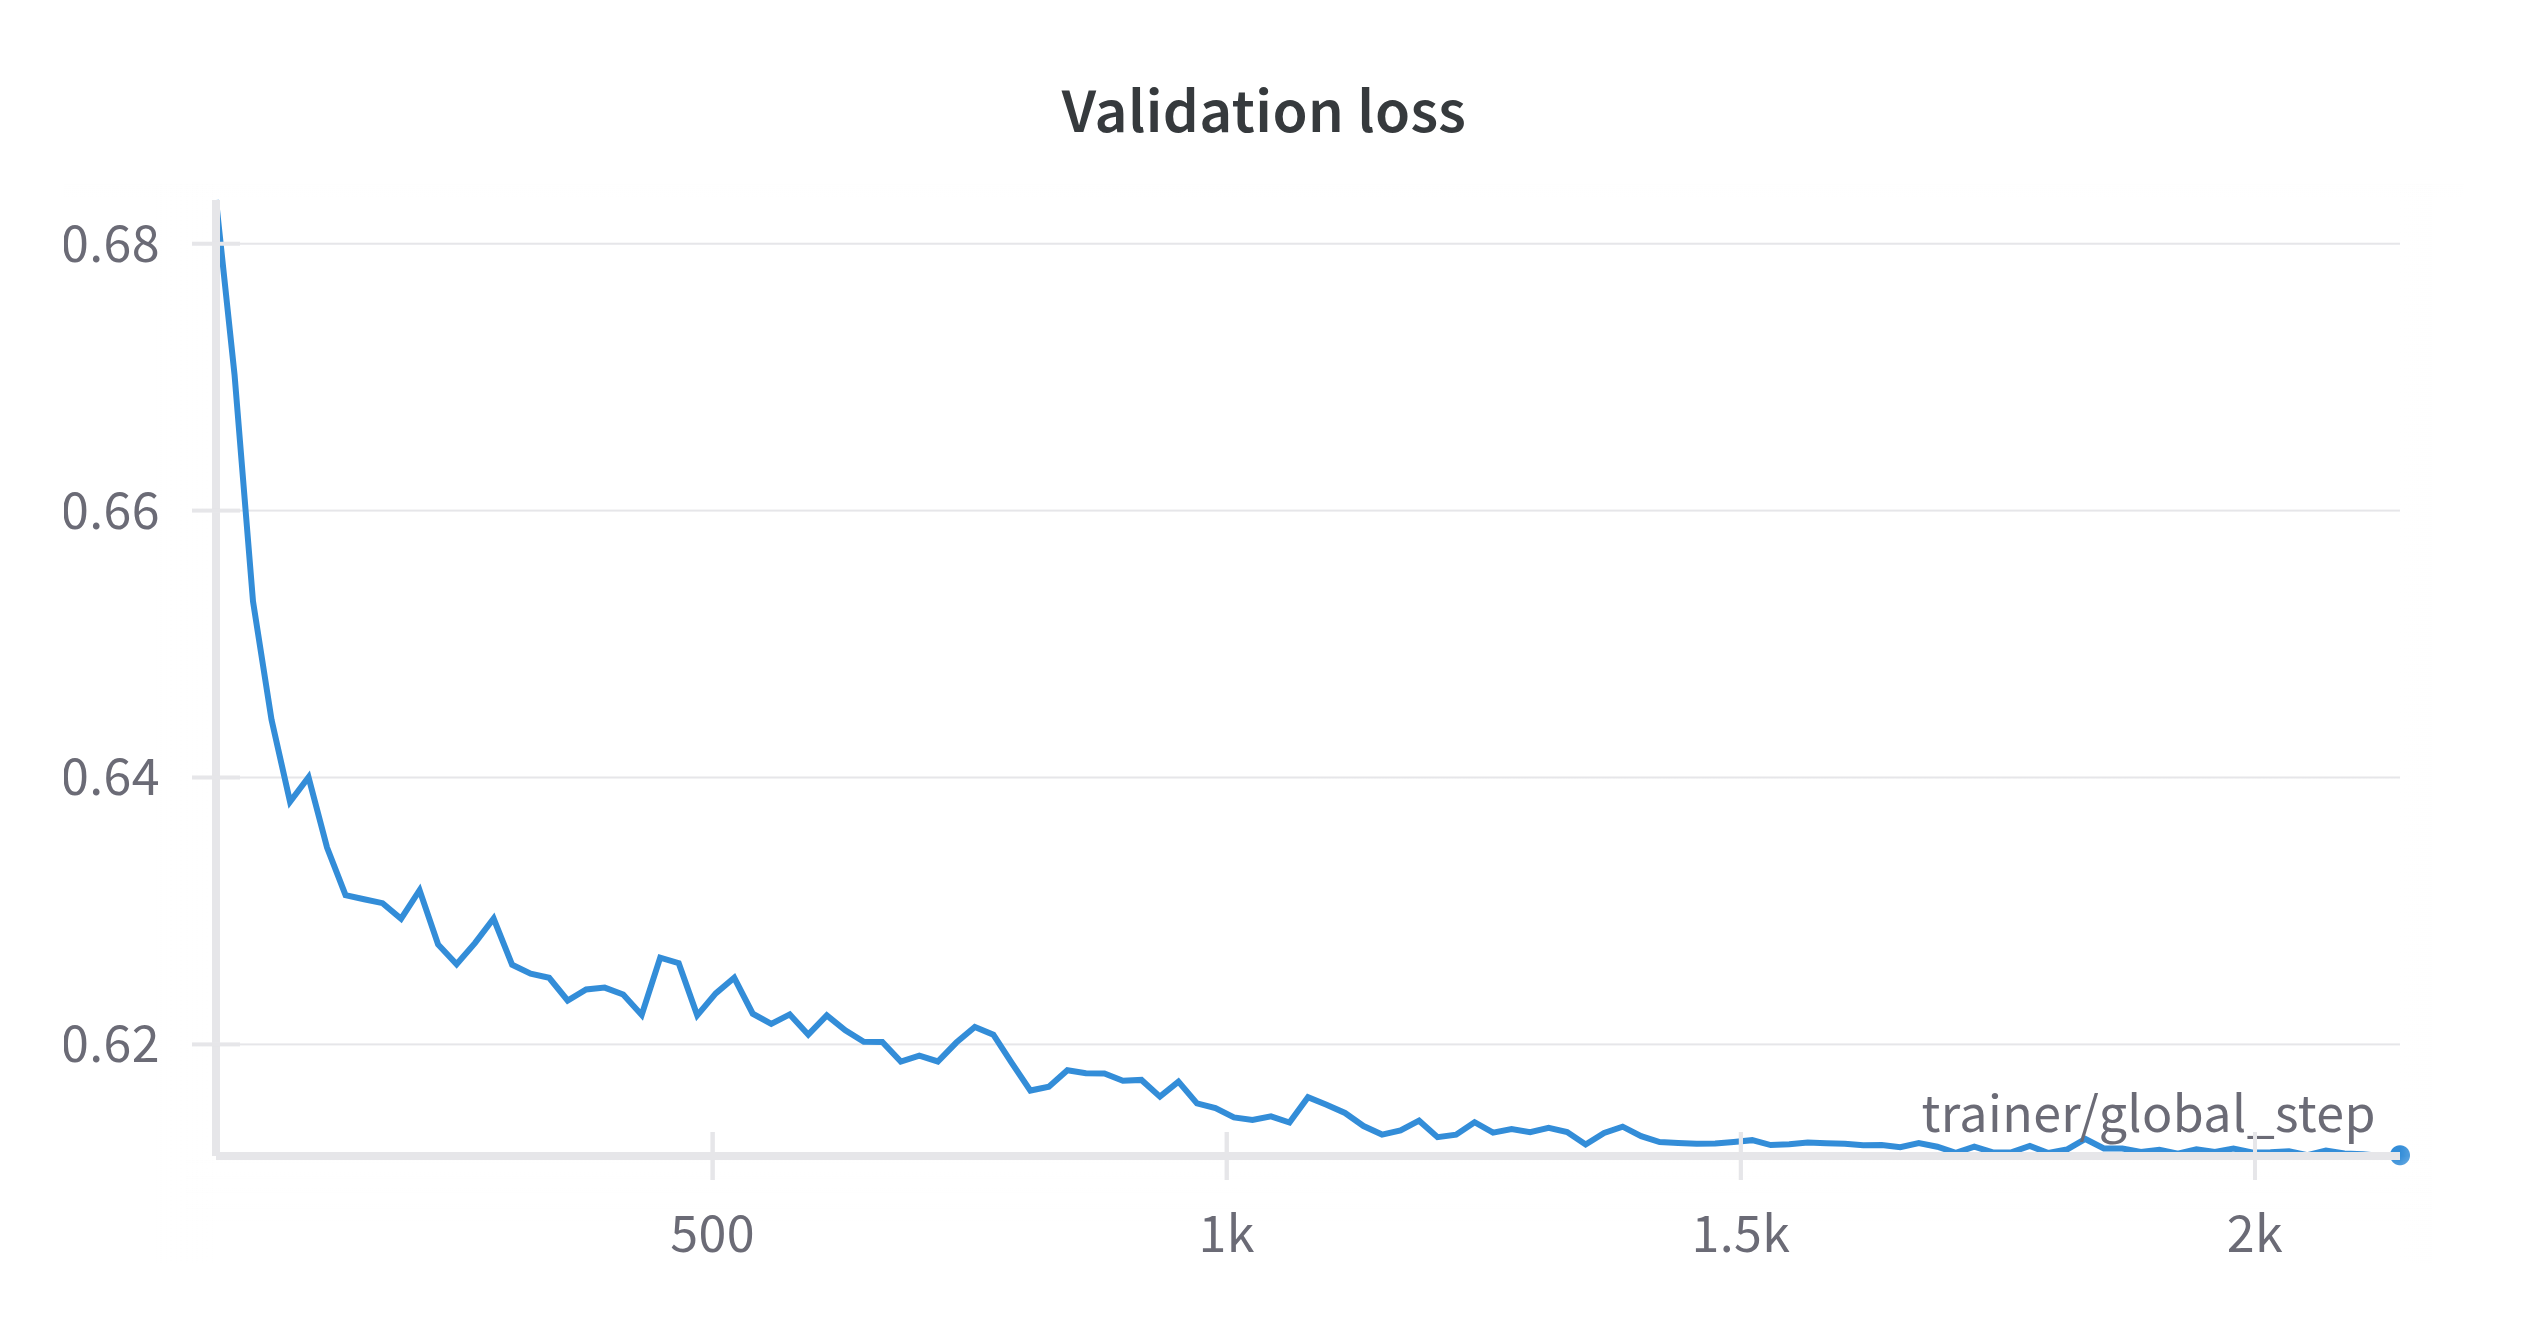

## Other experiments

![train acc.png](\+fprnQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKKiAAr6ATp9sECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkK+AALx8/bVOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgUVEIBX0InTbQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIV0AAXr7+WidAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBggoIwCvoxOk2AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECOQrIAAvX3+tEyBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgEBBBQTgFXTidJsAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE8hUQgJevv9YJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAoKACAvAKOnG6TYAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL5CgjAy9df6wQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQUAEBeAWdON0mQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgXwFBODl6691AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECiogAC8gk6cbhMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAvgIC8PL11zoBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIFFRAAF5BJ063CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCBfAQF4+fprnQABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQKKiAAr6ATp9sECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkK+AALx8/bVOgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgUVEIBX0InTbQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBDIV0AAXr7+WidAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBggr8f1/DUSNmUNusAAAAAElFTkSuQmCC)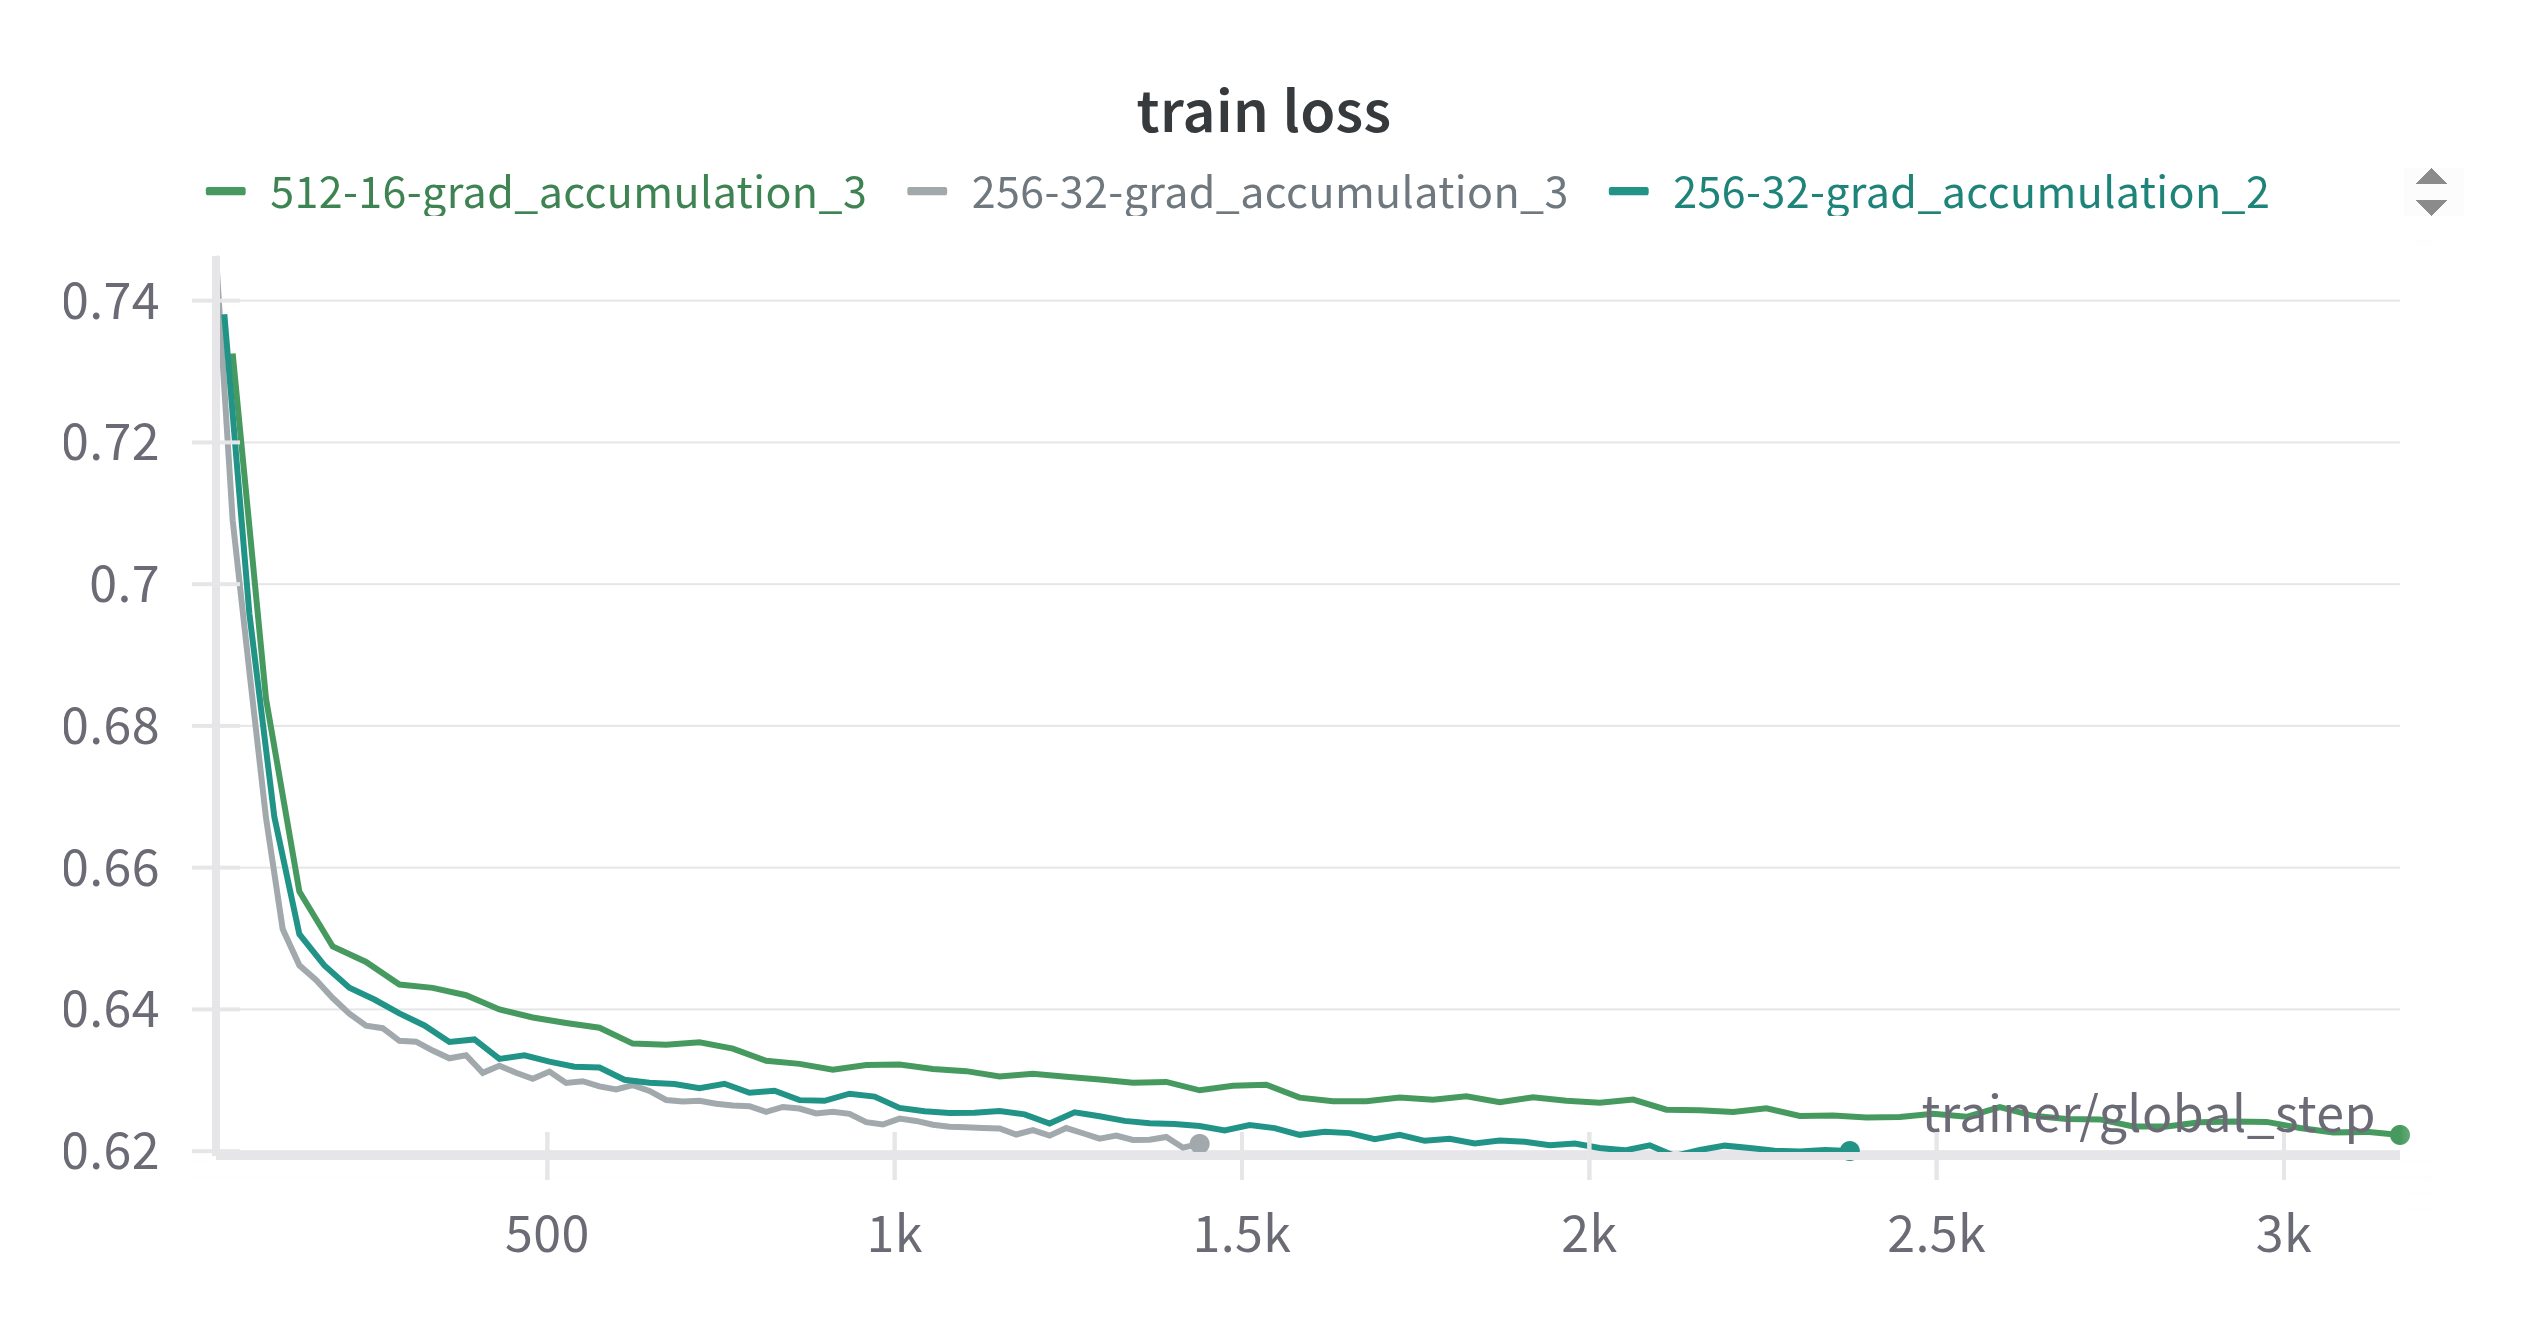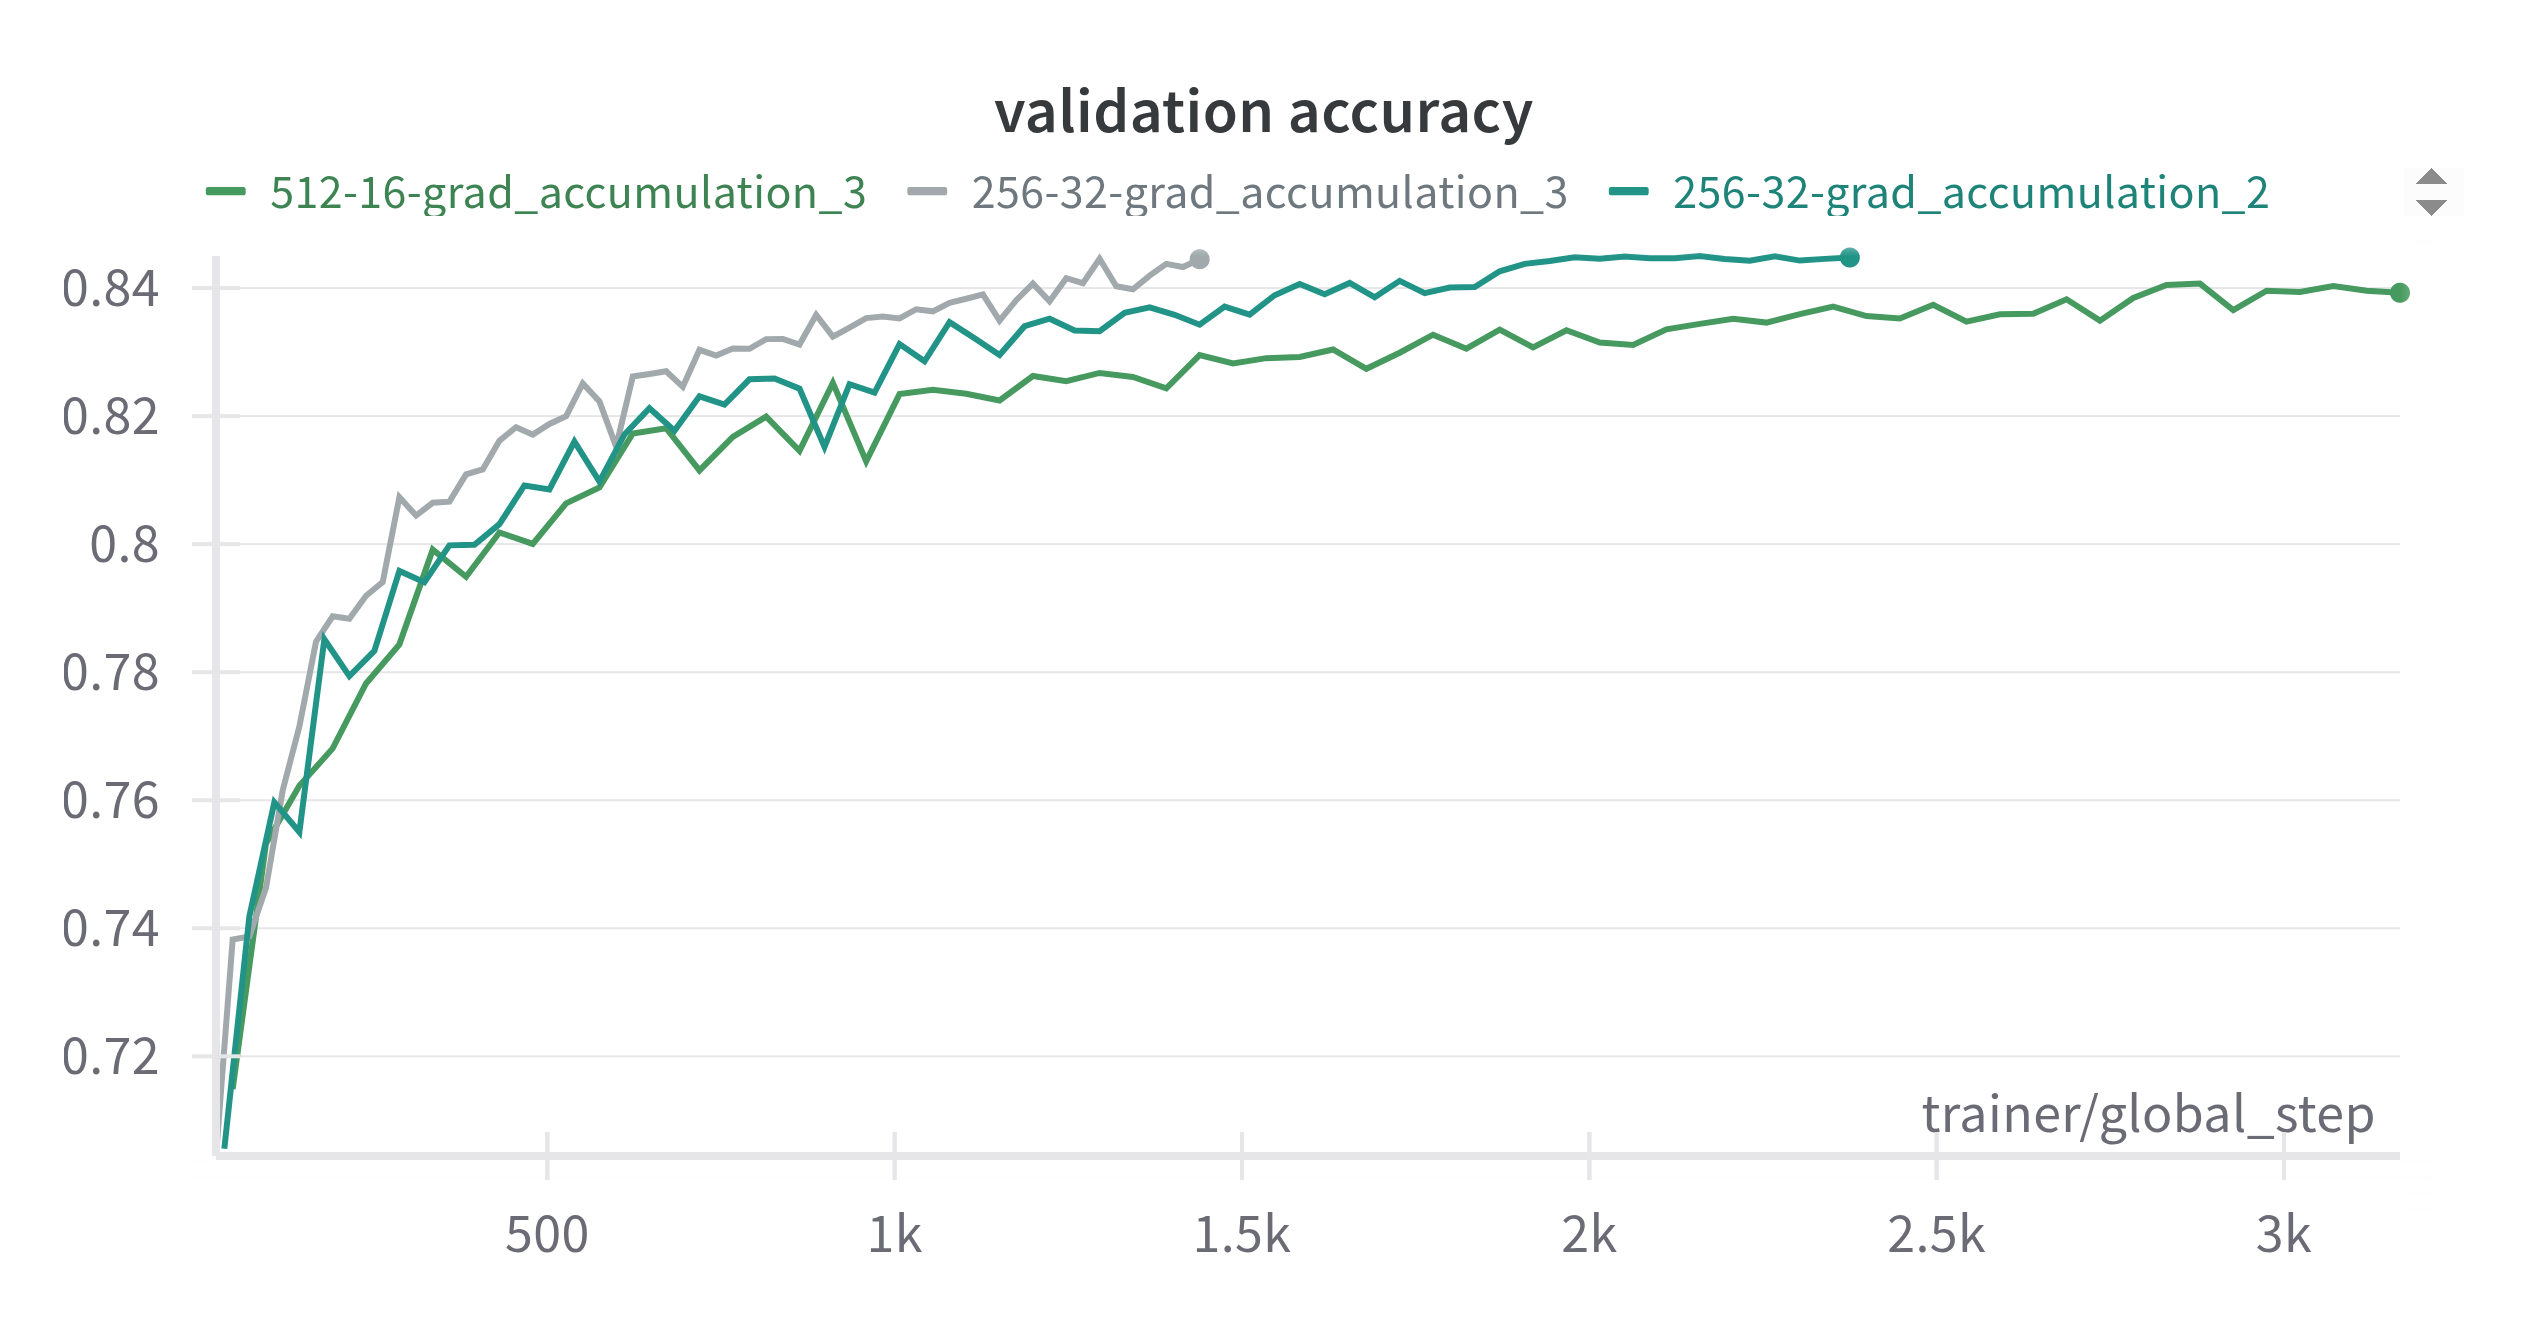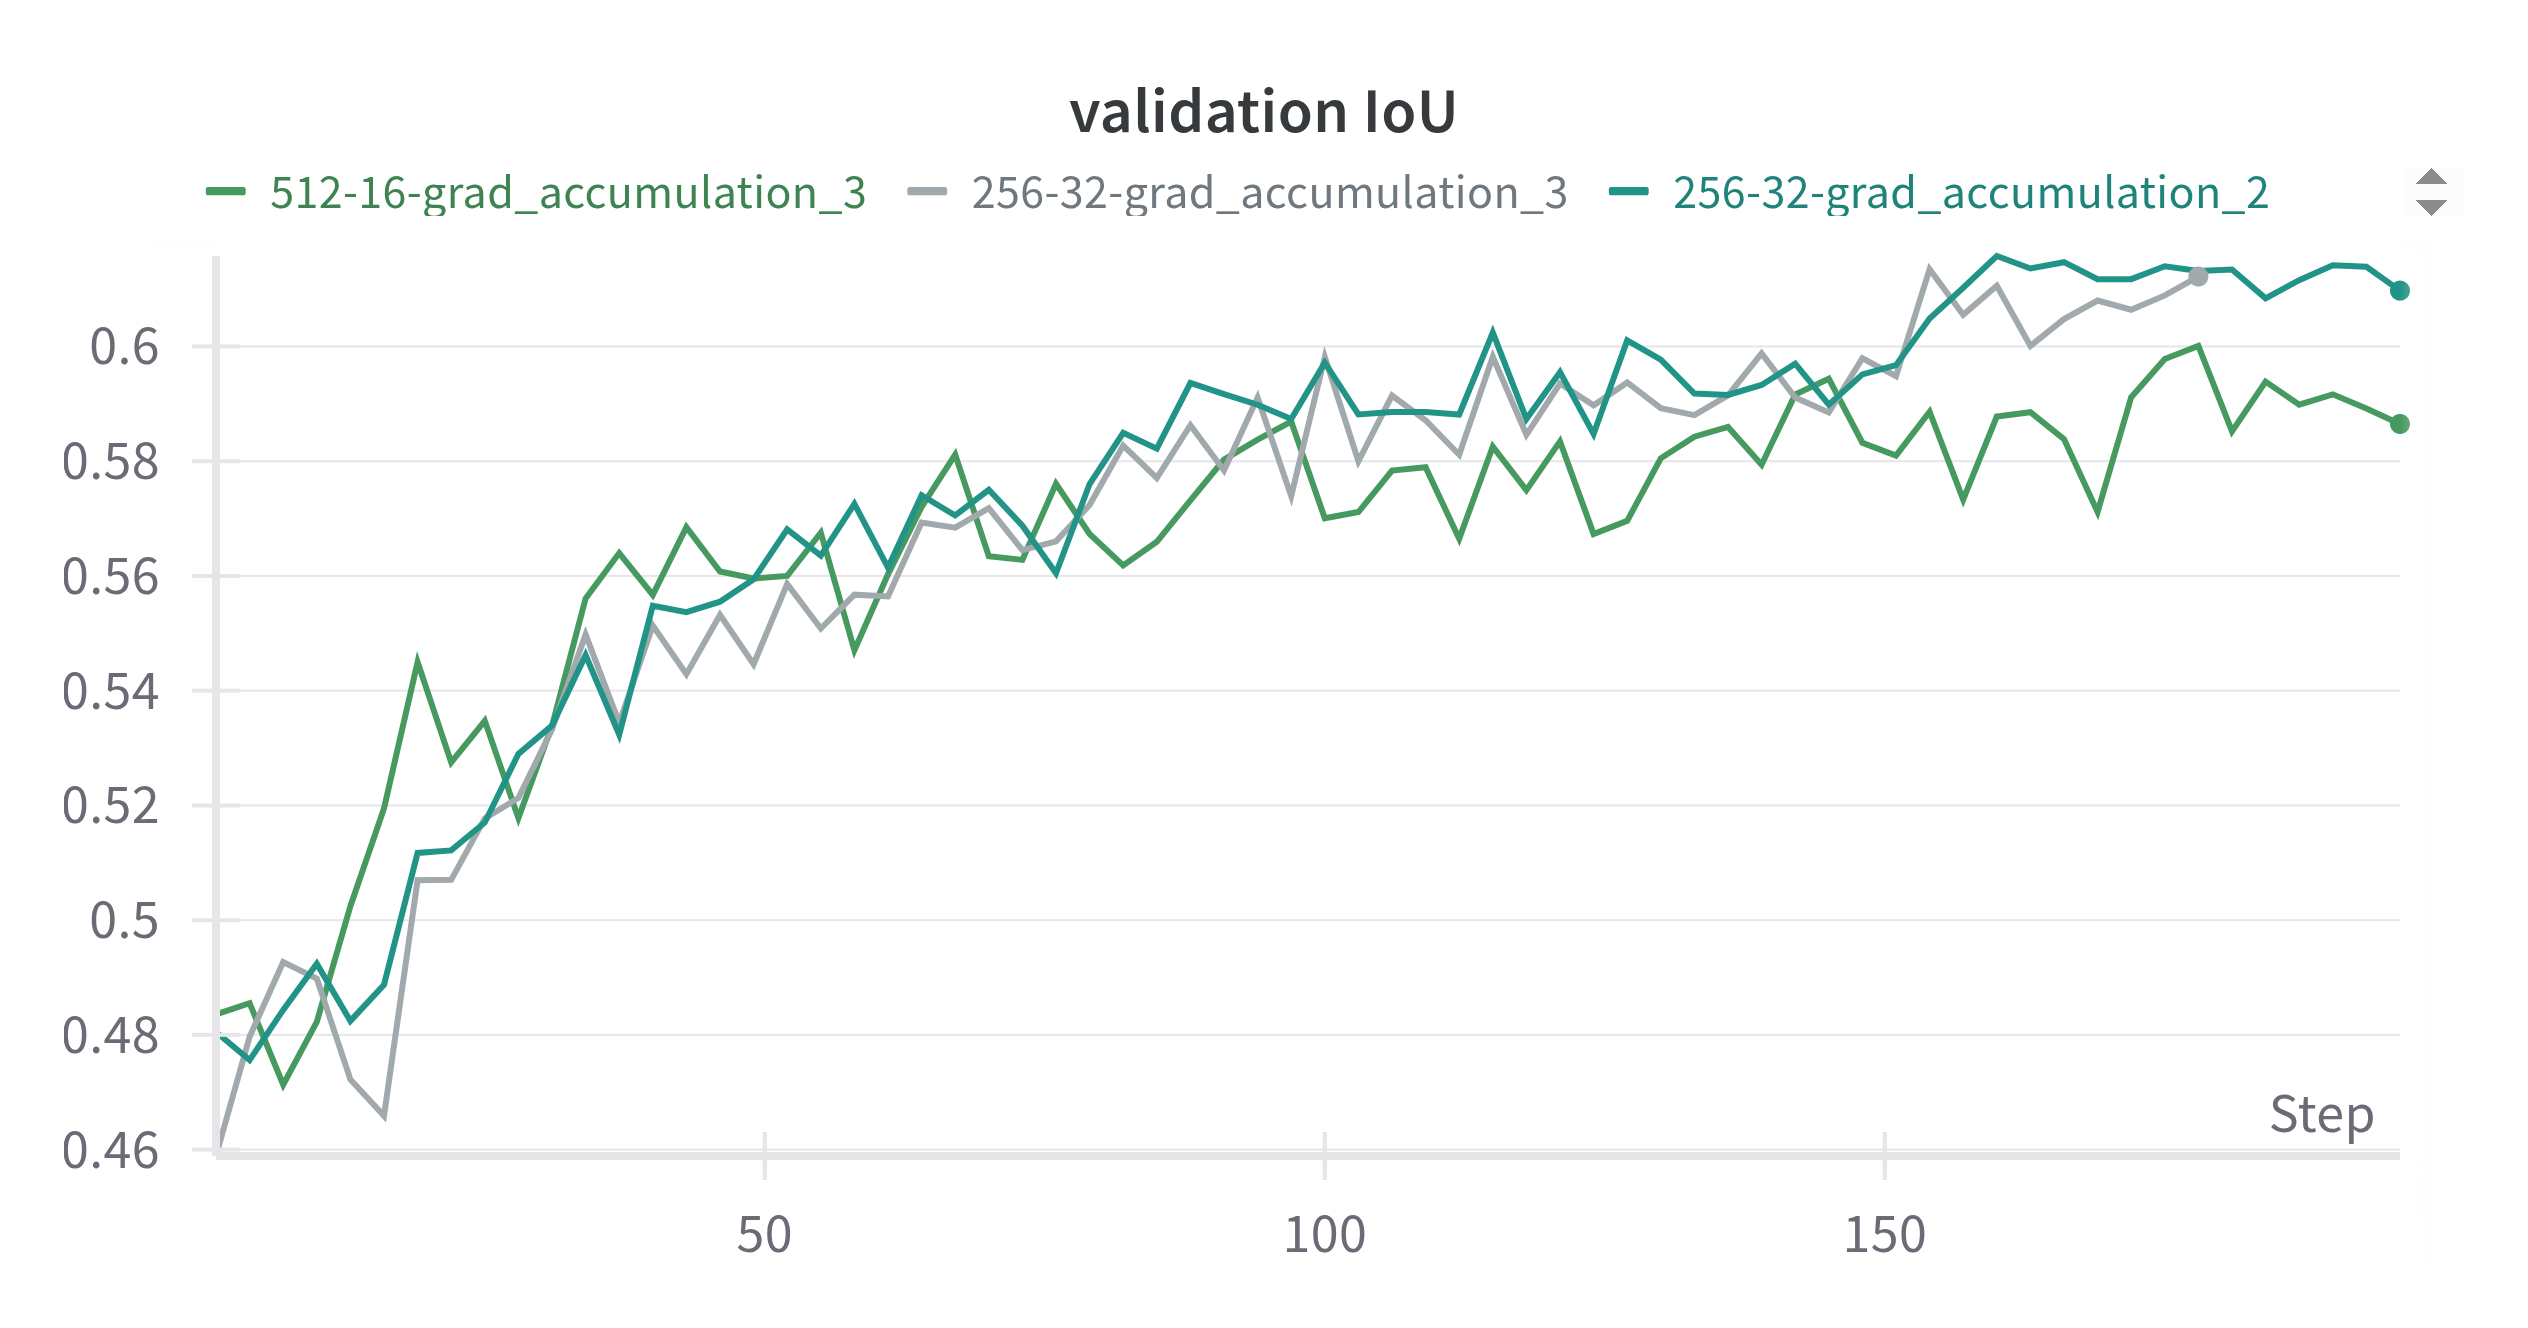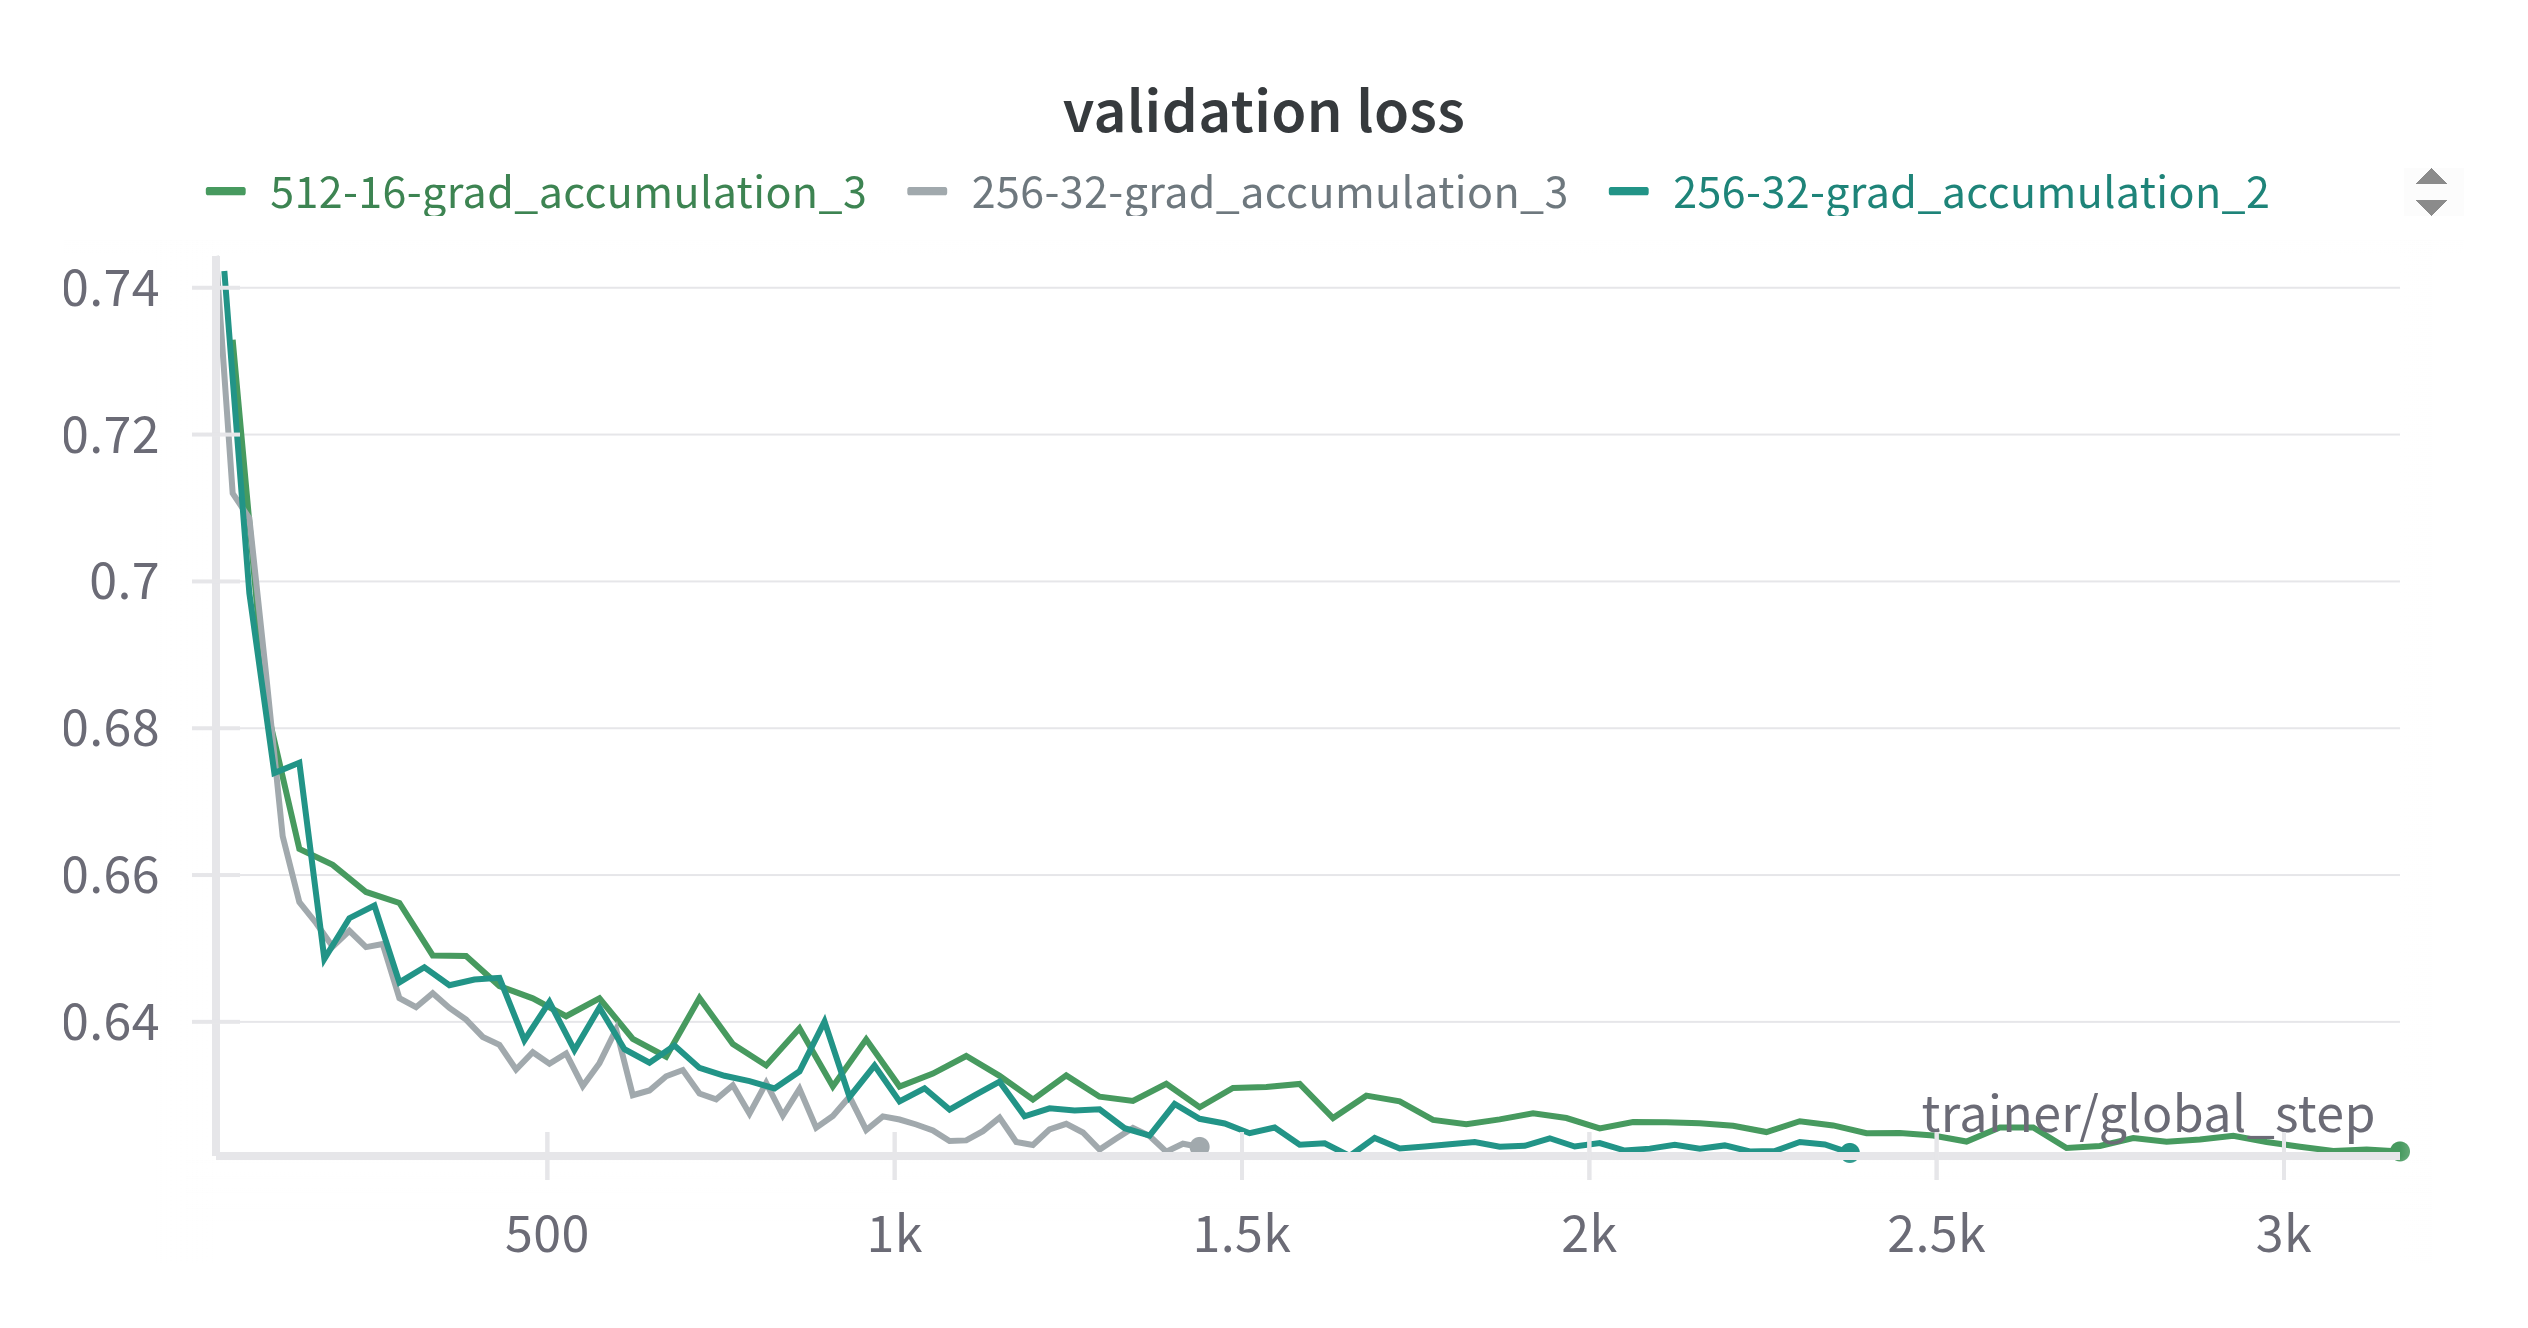

# Limitations and conclusions

### **Platform time limitation**

We tried to use the Colab free plan, but we had a maximum of 2 hours of GPU usage every 24 hours, so we discovered Kaggle. \\
Kaggle's free plan has a maximum of 30 hours of GPU usage. \\
To overcome the time limit, we simply created 2 accounts, both on Colab and Kaggle and used them for our experiments, and also benefited from the parallel execution of different experiments (ie. one with batch_size = 32 and one with batch_size = 64).

### **GPU memory limitation**
Both on Colab and Kaggle, the free plan allows to use a maximum of 16 GB of GPU memory, which leads to some constraints during training:
- Image size: increasing it, increases the number of trainable parameters (ie. in convolutions)
- Batch size: increasing it, increases the size of the matrices that the algorithm operates on

So we are constrained to either:
- Use 512x512 images with batch_size <= 20, which is quite small and leads to unstable weight updates
- Use 256x256 images with batch_size <= 64, but some details of the original images get lost, leading to a potential worse mask prediction

Out of the two options, we chose to use a smaller image size but a larger batch_size, as our experiments suggested that is the best one.

Also, to workaround this limitation, we used *gradient accumulation*, which can virtually increase batch size: using batch_size = 16 but accumulate_grad_batches = 4 we thought we could obtain results similar to batch_size = 16 * 4 = 64. \\
However, our experiments proved that the results of a 512x512, 16\*4 run are still worse than 256x256, 32\*4.


### Conclusions

We were not able to fully replicate the results in the paper, as some features of the implementation were missing or written in an ambiguous way. \\
However, we got results which are quite close, considering also the hardware limitations that we had.

# References

* https://www.geeksforgeeks.org/u-net-architecture-explained/